# Task 1 Results Figure
Kai Sandbrink

2024-03-09

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle
from utils import format_axis

import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from utils import flatten

analysis_folder = os.path.join('panels', 'fig_task1_2023')
os.makedirs(analysis_folder, exist_ok=True)

## Panel A: Single-Episode Observations
### General Options

In [2]:
effs_to_plot = [1, 0.75, 0.25, 0]
n_steps = 50
smoothing_window = 8
ylim = (0, 0.3)

exp_date = '518-525-619-706'

### Humans

In [6]:
from human_utils_project import get_clean_data, sort_train_test

day = 'day2'

# day1_test_mask_cutoff = {
#     "groupA": {"lower": 10, "upper": 90},
#     "groupB": {"lower": 8, "upper": 72}
# }

day1_test_mask_cutoff = None

human_data_file_base = '/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis'

group = None

df, effs_train, effs_test, test_start = get_clean_data(day = int(day[-1]), exp_date = exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, group=group, file_base=human_data_file_base, exclude_based_on_day3 = True)

cmap_humans = mpl.colormaps['Greens']

/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis/human_utils_project.py:1281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_day3['group'] = False


In [4]:
transitions_train, transitions_test = sort_train_test(df['transitions_ep_rightwrong'], df['effs'], test_start[0])
observations = [transitions_test[:,3], transitions_test[:,2], transitions_test[:,1], transitions_test[:,0]] ## plotting highest efficacy first
observations = [observation == 0.5 for observation in observations]

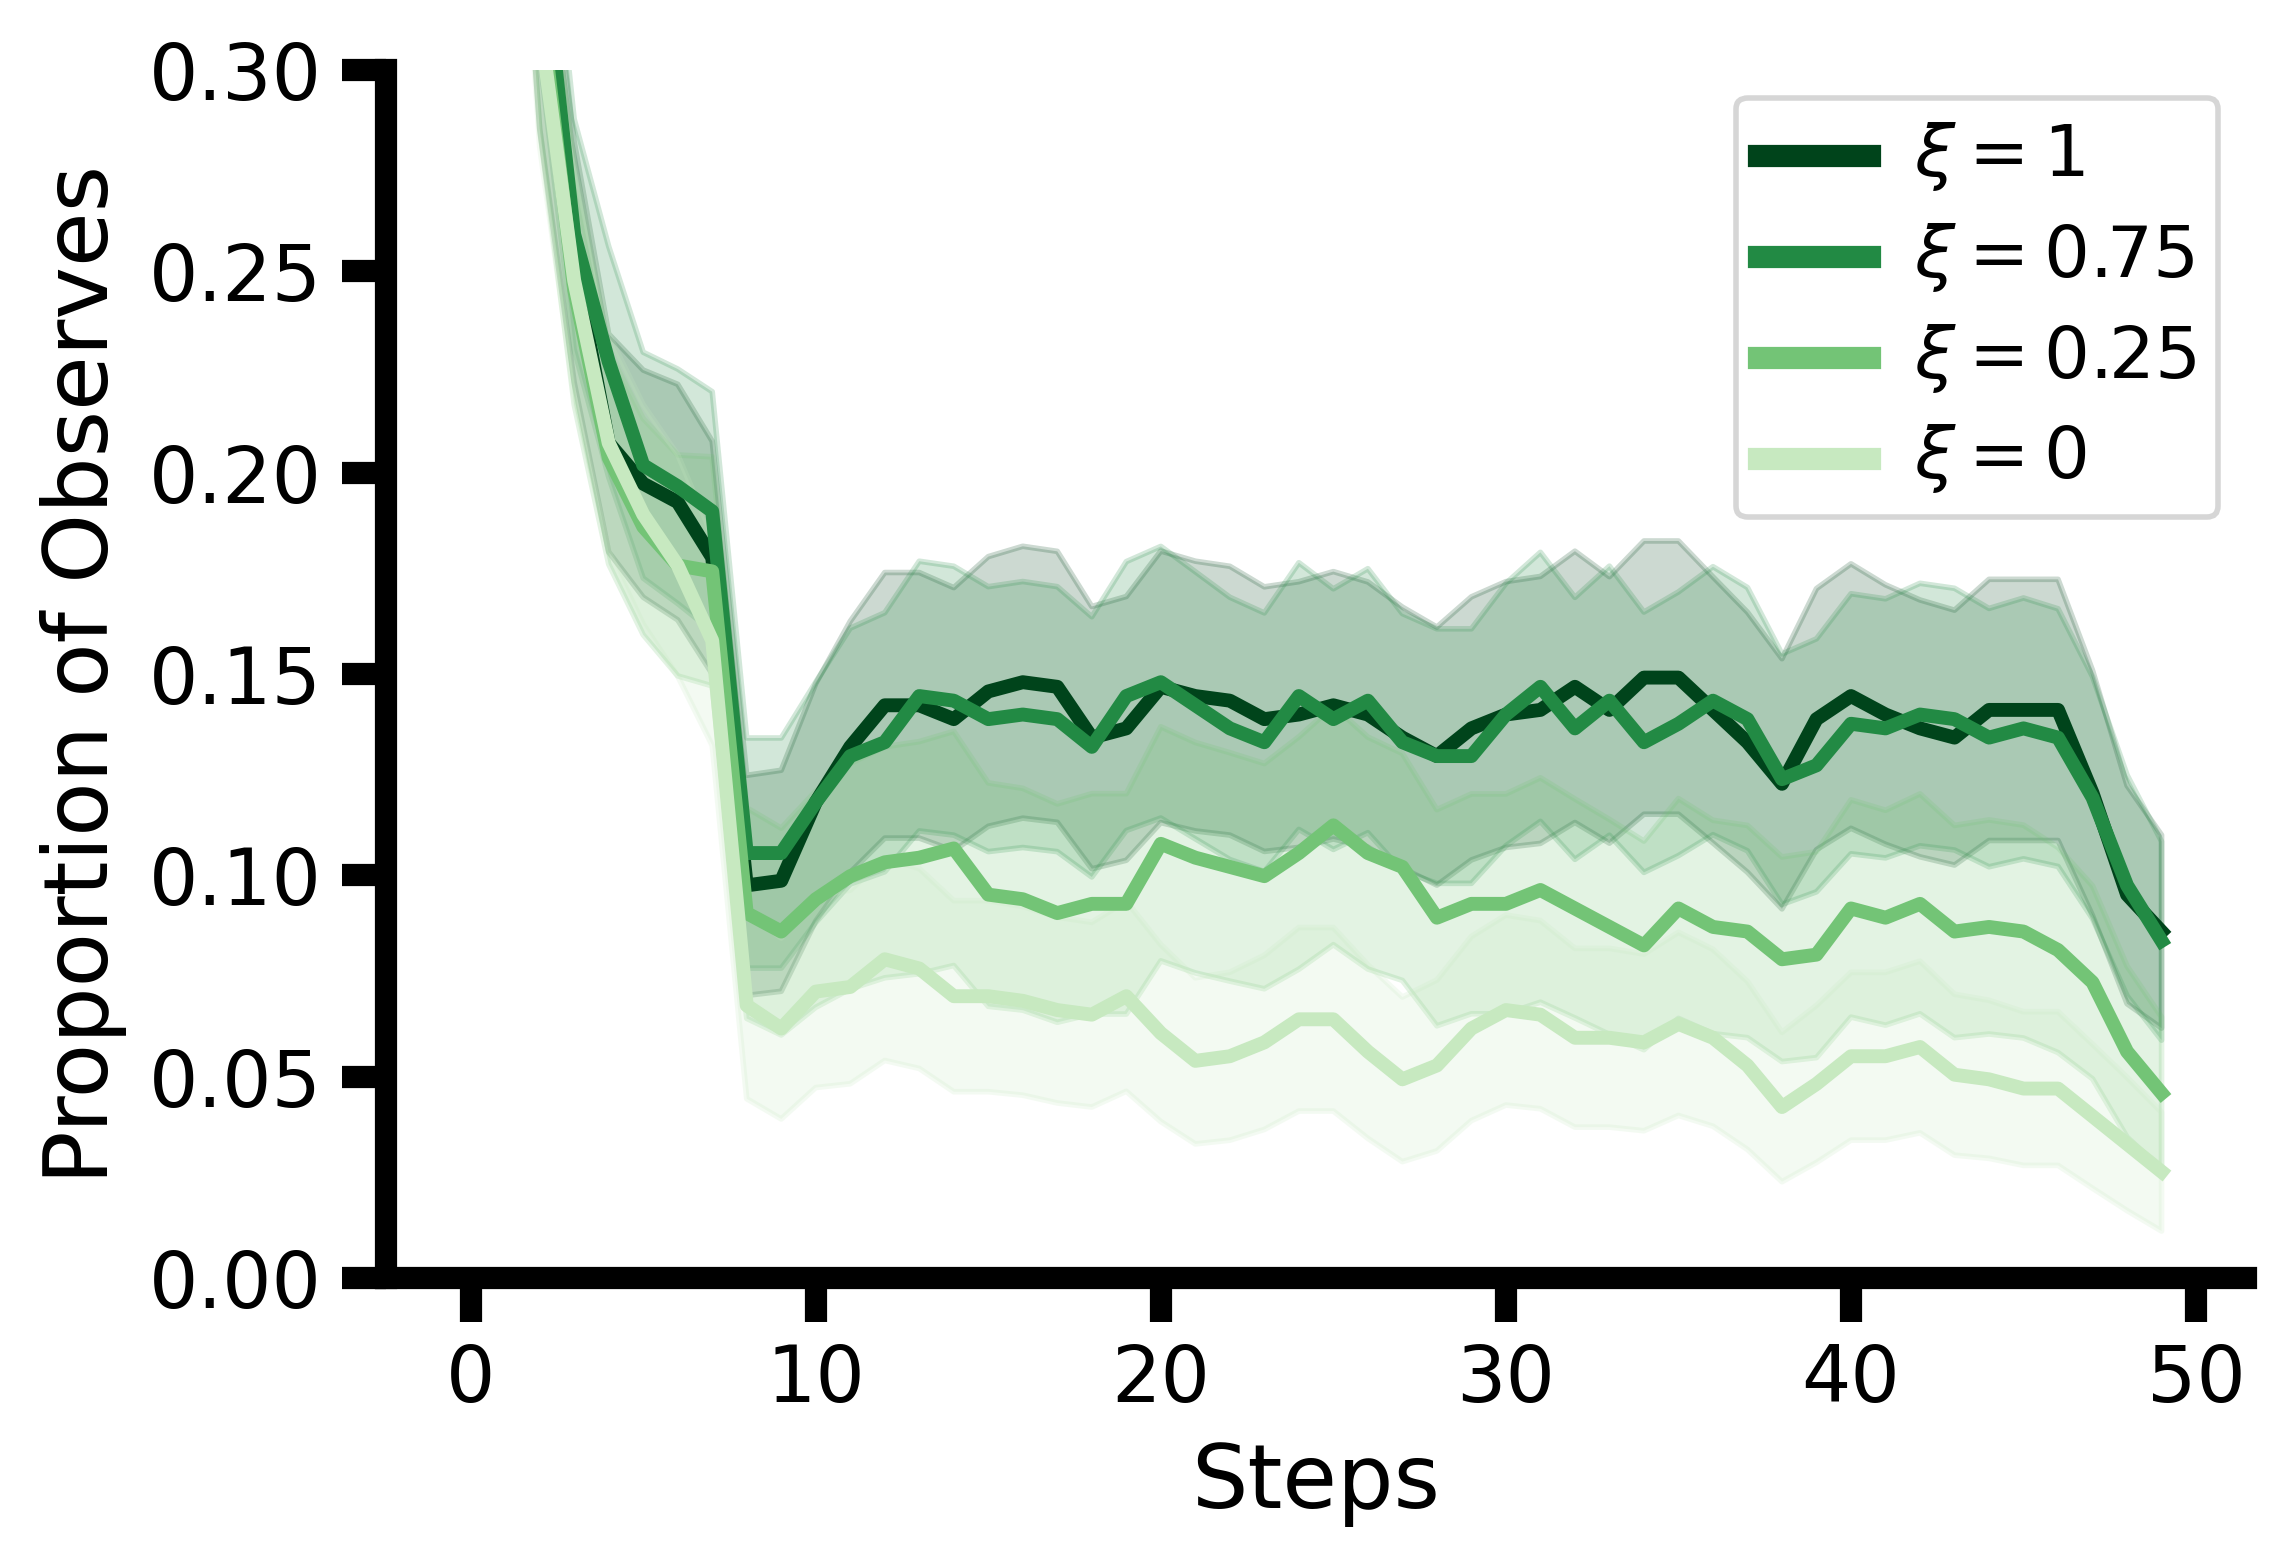

In [25]:
mean_peek_probs = np.array([observation.mean(axis=0) for observation in observations])
stderr_peek_probs = np.array([observation.std(axis=0)/np.sqrt(observation.shape[0]) for observation in observations])

### smoothing based on rolling average
if smoothing_window > 1:
    mean_peek_probs = pd.DataFrame(mean_peek_probs).apply(lambda x: x.rolling(window=smoothing_window, min_periods=1).mean(), axis=1).values
    stderr_peek_probs = pd.DataFrame(stderr_peek_probs).apply(lambda x: x.rolling(window=smoothing_window, min_periods=1).mean(), axis=1).values

## create figure
fig = plt.figure(dpi=400)
ax = fig.add_subplot(111)

steps = range(mean_peek_probs.shape[1])

for i in range(len(mean_peek_probs)):
    ax.plot(steps, mean_peek_probs[i], label=r"$\xi=$" + str(effs_to_plot[i]), color=cmap_humans((len(mean_peek_probs) - i)/len(mean_peek_probs)))
    ax.fill_between(steps, mean_peek_probs[i] - stderr_peek_probs[i], mean_peek_probs[i] + stderr_peek_probs[i], color=cmap_humans((len(mean_peek_probs) - i)/len(mean_peek_probs)), alpha=0.2)

ax.legend()

ax.set_xlabel("Steps")
ax.set_ylabel("Proportion of Observes")

if ylim is not None:
    ax.set_ylim(ylim)

format_axis(ax)

In [26]:
fig.savefig(os.path.join(analysis_folder, 'observes_episode_humans.png'))
fig.savefig(os.path.join(analysis_folder, 'observes_episode_humans.svg'))

#### Stats

In [7]:
len(df)

82

In [5]:
cropped_observations = [observation[:,15:].mean(axis=1) for observation in observations]
plotted_levels = effs_to_plot

NameError: name 'observations' is not defined

In [27]:
## MEANS AND SEMS
print("Overall N", len(df))

for level, obs in zip(plotted_levels, cropped_observations):
    print("Test Controllability ", level)
    print("Mean ", obs.mean())
    print("StdErr ", obs.std()/np.sqrt(obs.shape[0]))
    print("N", obs.shape[0])

Overall N 109


NameError: name 'plotted_levels' is not defined

In [6]:
## TUKEY'S
groups = flatten([[level]*len(obs) for level, obs in zip(plotted_levels, cropped_observations)])

# Perform Tukey's HSD test
tukey_result = pairwise_tukeyhsd(endog=flatten(cropped_observations), groups=groups, alpha=0.05)

# Print the results
print(tukey_result)


NameError: name 'plotted_levels' is not defined

In [7]:
from human_utils_behavioral_analysis import fit_mixed_effects_glm

glm = fit_mixed_effects_glm(df, 'n_observes')
glm.summary()


NameError: name 'df' is not defined

### APE-trained neural networks

In [30]:
from settings_anal import pepe_human_ape_models as ape_models
from utils_project import load_modelrun_files
from settings_anal import pepe_human_ape_traj_timestamp as traj_timestamp

traj_base = os.path.join('data', 'eval', 'pepe', )

cmap_apes = mpl.colormaps['Blues']
taus_to_plot = [0, 0.5, 1]

rewss_taus_ape, counterss_peeks_taus_ape, control_errss_taus_ape, trajss_actions_taus_ape, trajss_logits_taus_ape, trajss_ps_taus_ape = load_modelrun_files(ape_models, traj_timestamp, ape=True, traj_base=traj_base)

## select only the taus to plot
trajss_logits_taus_ape = np.array(trajss_logits_taus_ape)
trajss_logits_taus_ape = trajss_logits_taus_ape[:, ::4]

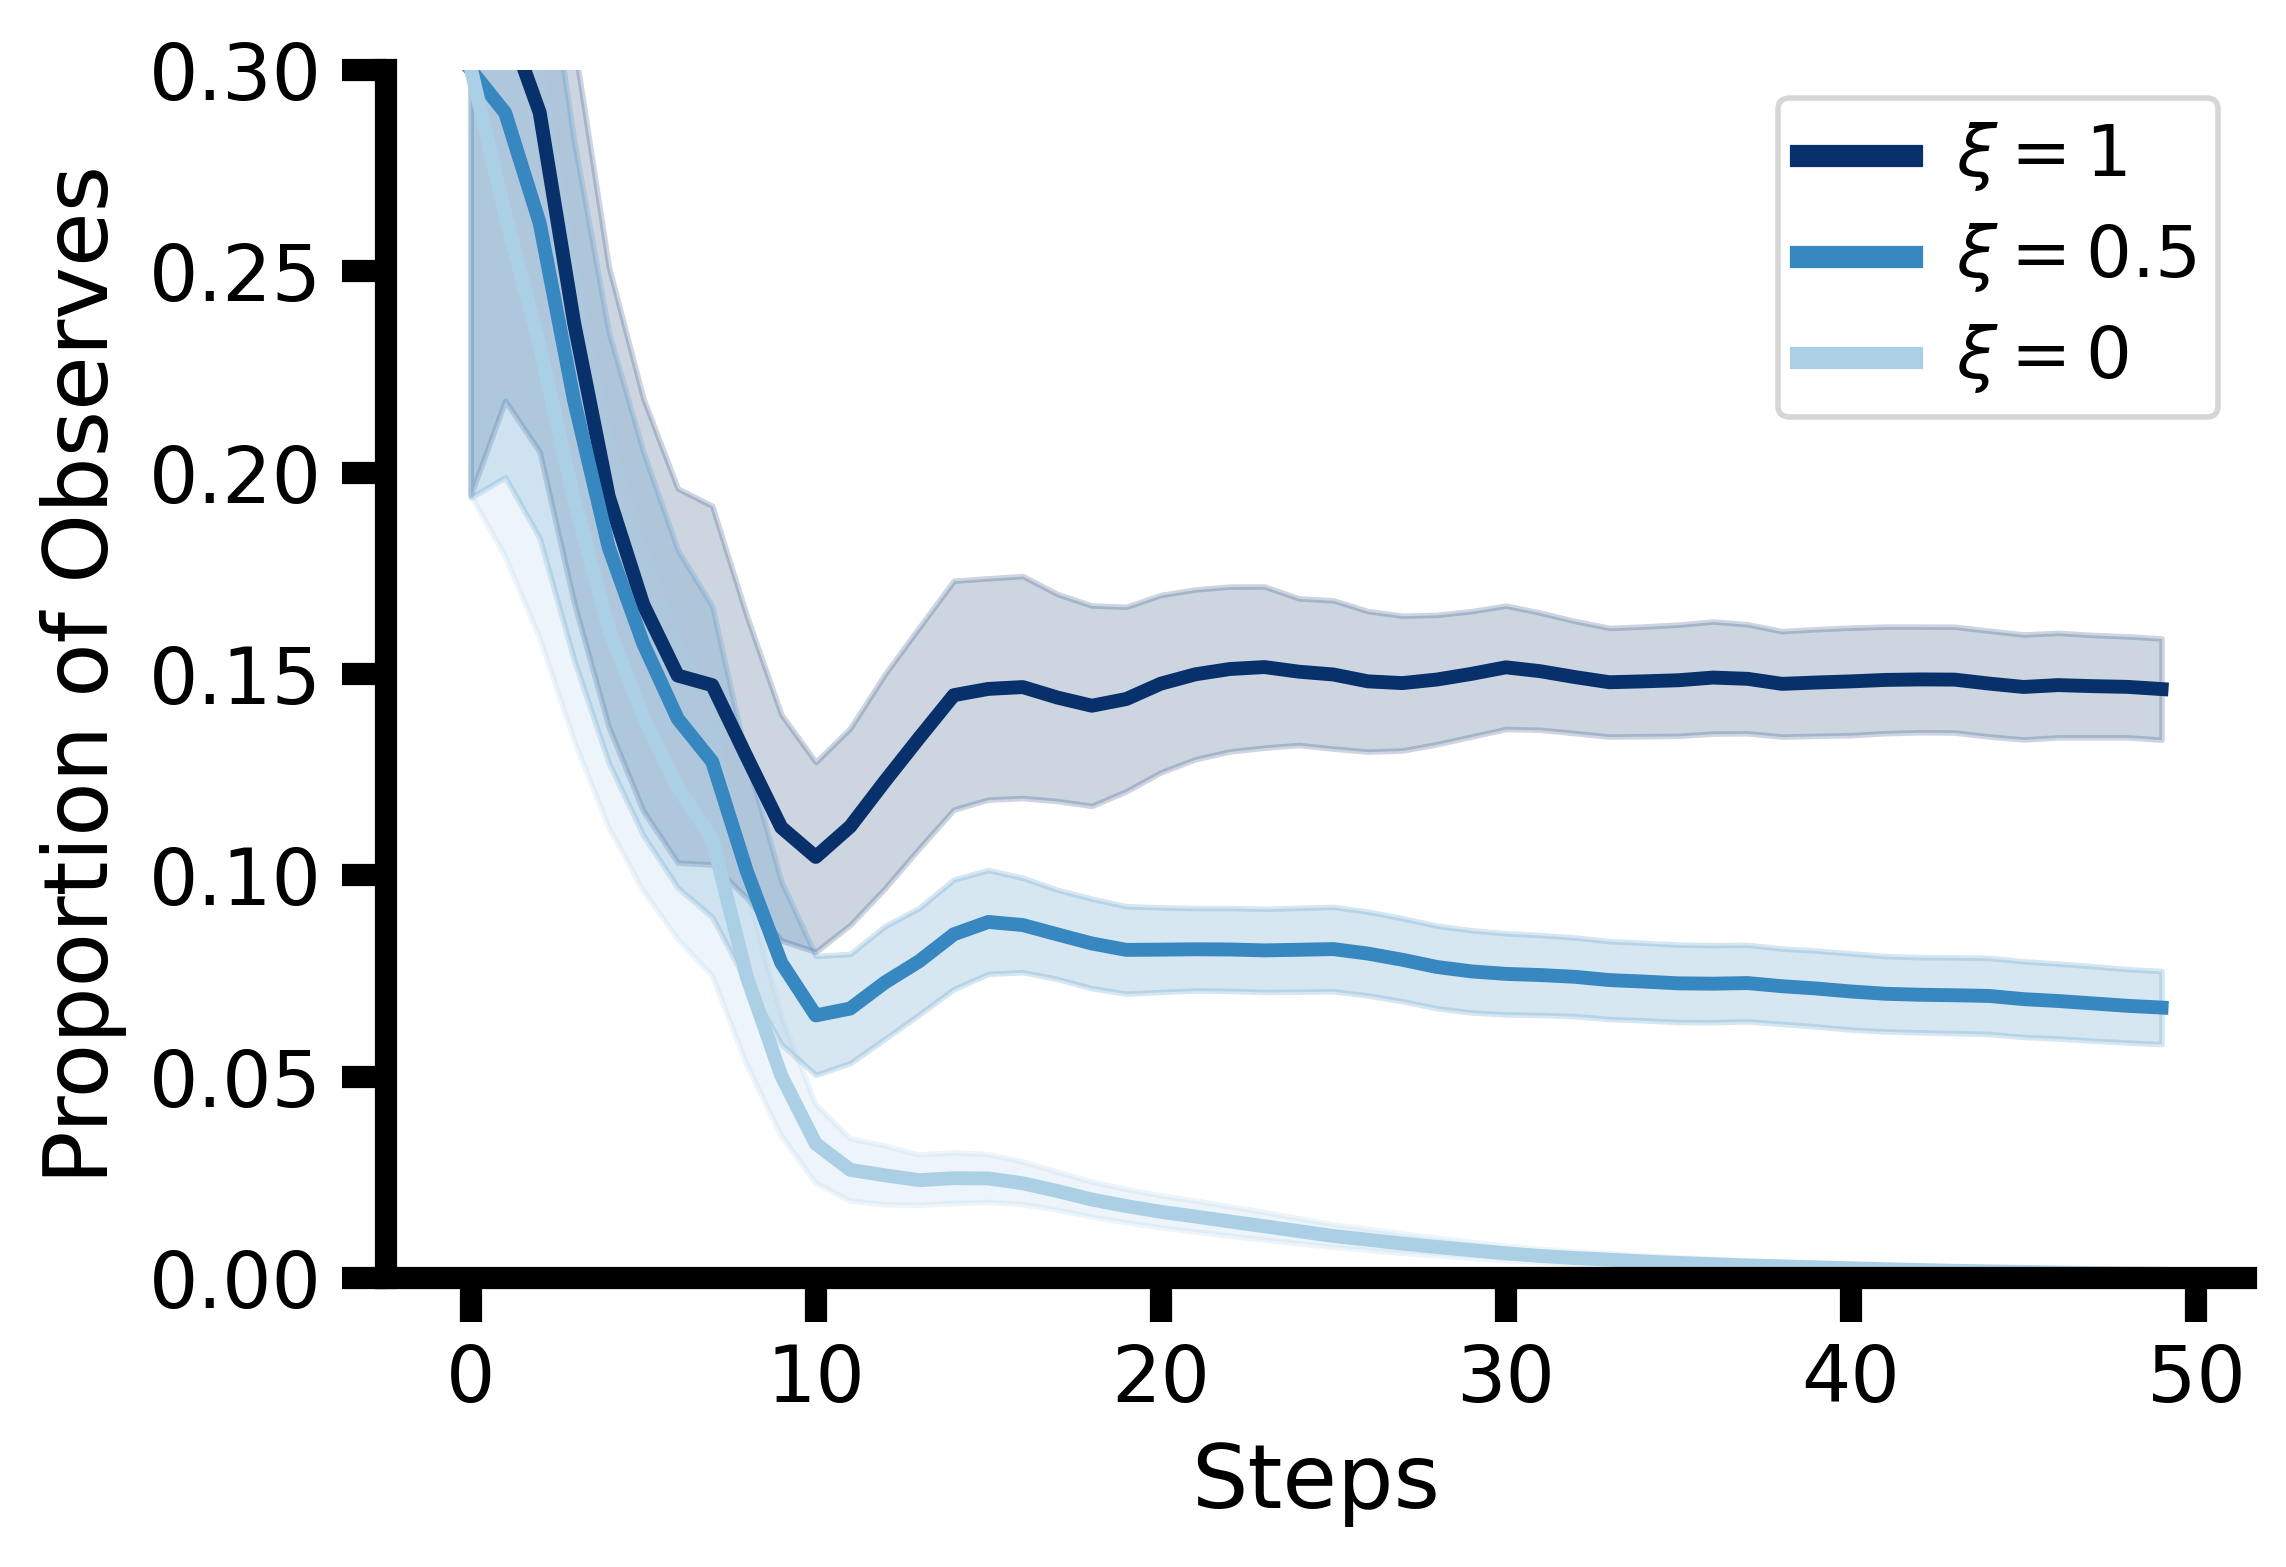

In [31]:
from test_analyses import frac_takes_lineplot

fig = frac_takes_lineplot(taus_to_plot, trajss_logits_taus_ape, ylim=ylim, smoothing_window=smoothing_window, cmap = cmap_apes, ylabel="Proportion of Observes")

In [32]:
fig.savefig(os.path.join(analysis_folder, 'observes_episode_apes.png'))
fig.savefig(os.path.join(analysis_folder, 'observes_episode_apes.svg'))

### No-APE Networks

In [33]:
from settings_anal import pepe_human_control_models as control_models
from settings_anal import pepe_human_control_traj_timestamp as traj_timestamp
from utils_project import load_modelrun_files

traj_base = os.path.join('data', 'eval', 'pepe', )

cmap_control = mpl.colormaps['Oranges']
taus_to_plot = [0, 0.5, 1]

rewss_taus_control, counterss_peeks_taus_control, _, trajss_actions_taus_control, trajss_logits_taus_control, trajss_ps_taus_control = load_modelrun_files(control_models, traj_timestamp, ape=False, traj_base=traj_base)

## select only the taus to plot
trajss_logits_taus_control = np.array(trajss_logits_taus_control)
trajss_logits_taus_control = trajss_logits_taus_control[:, ::4]

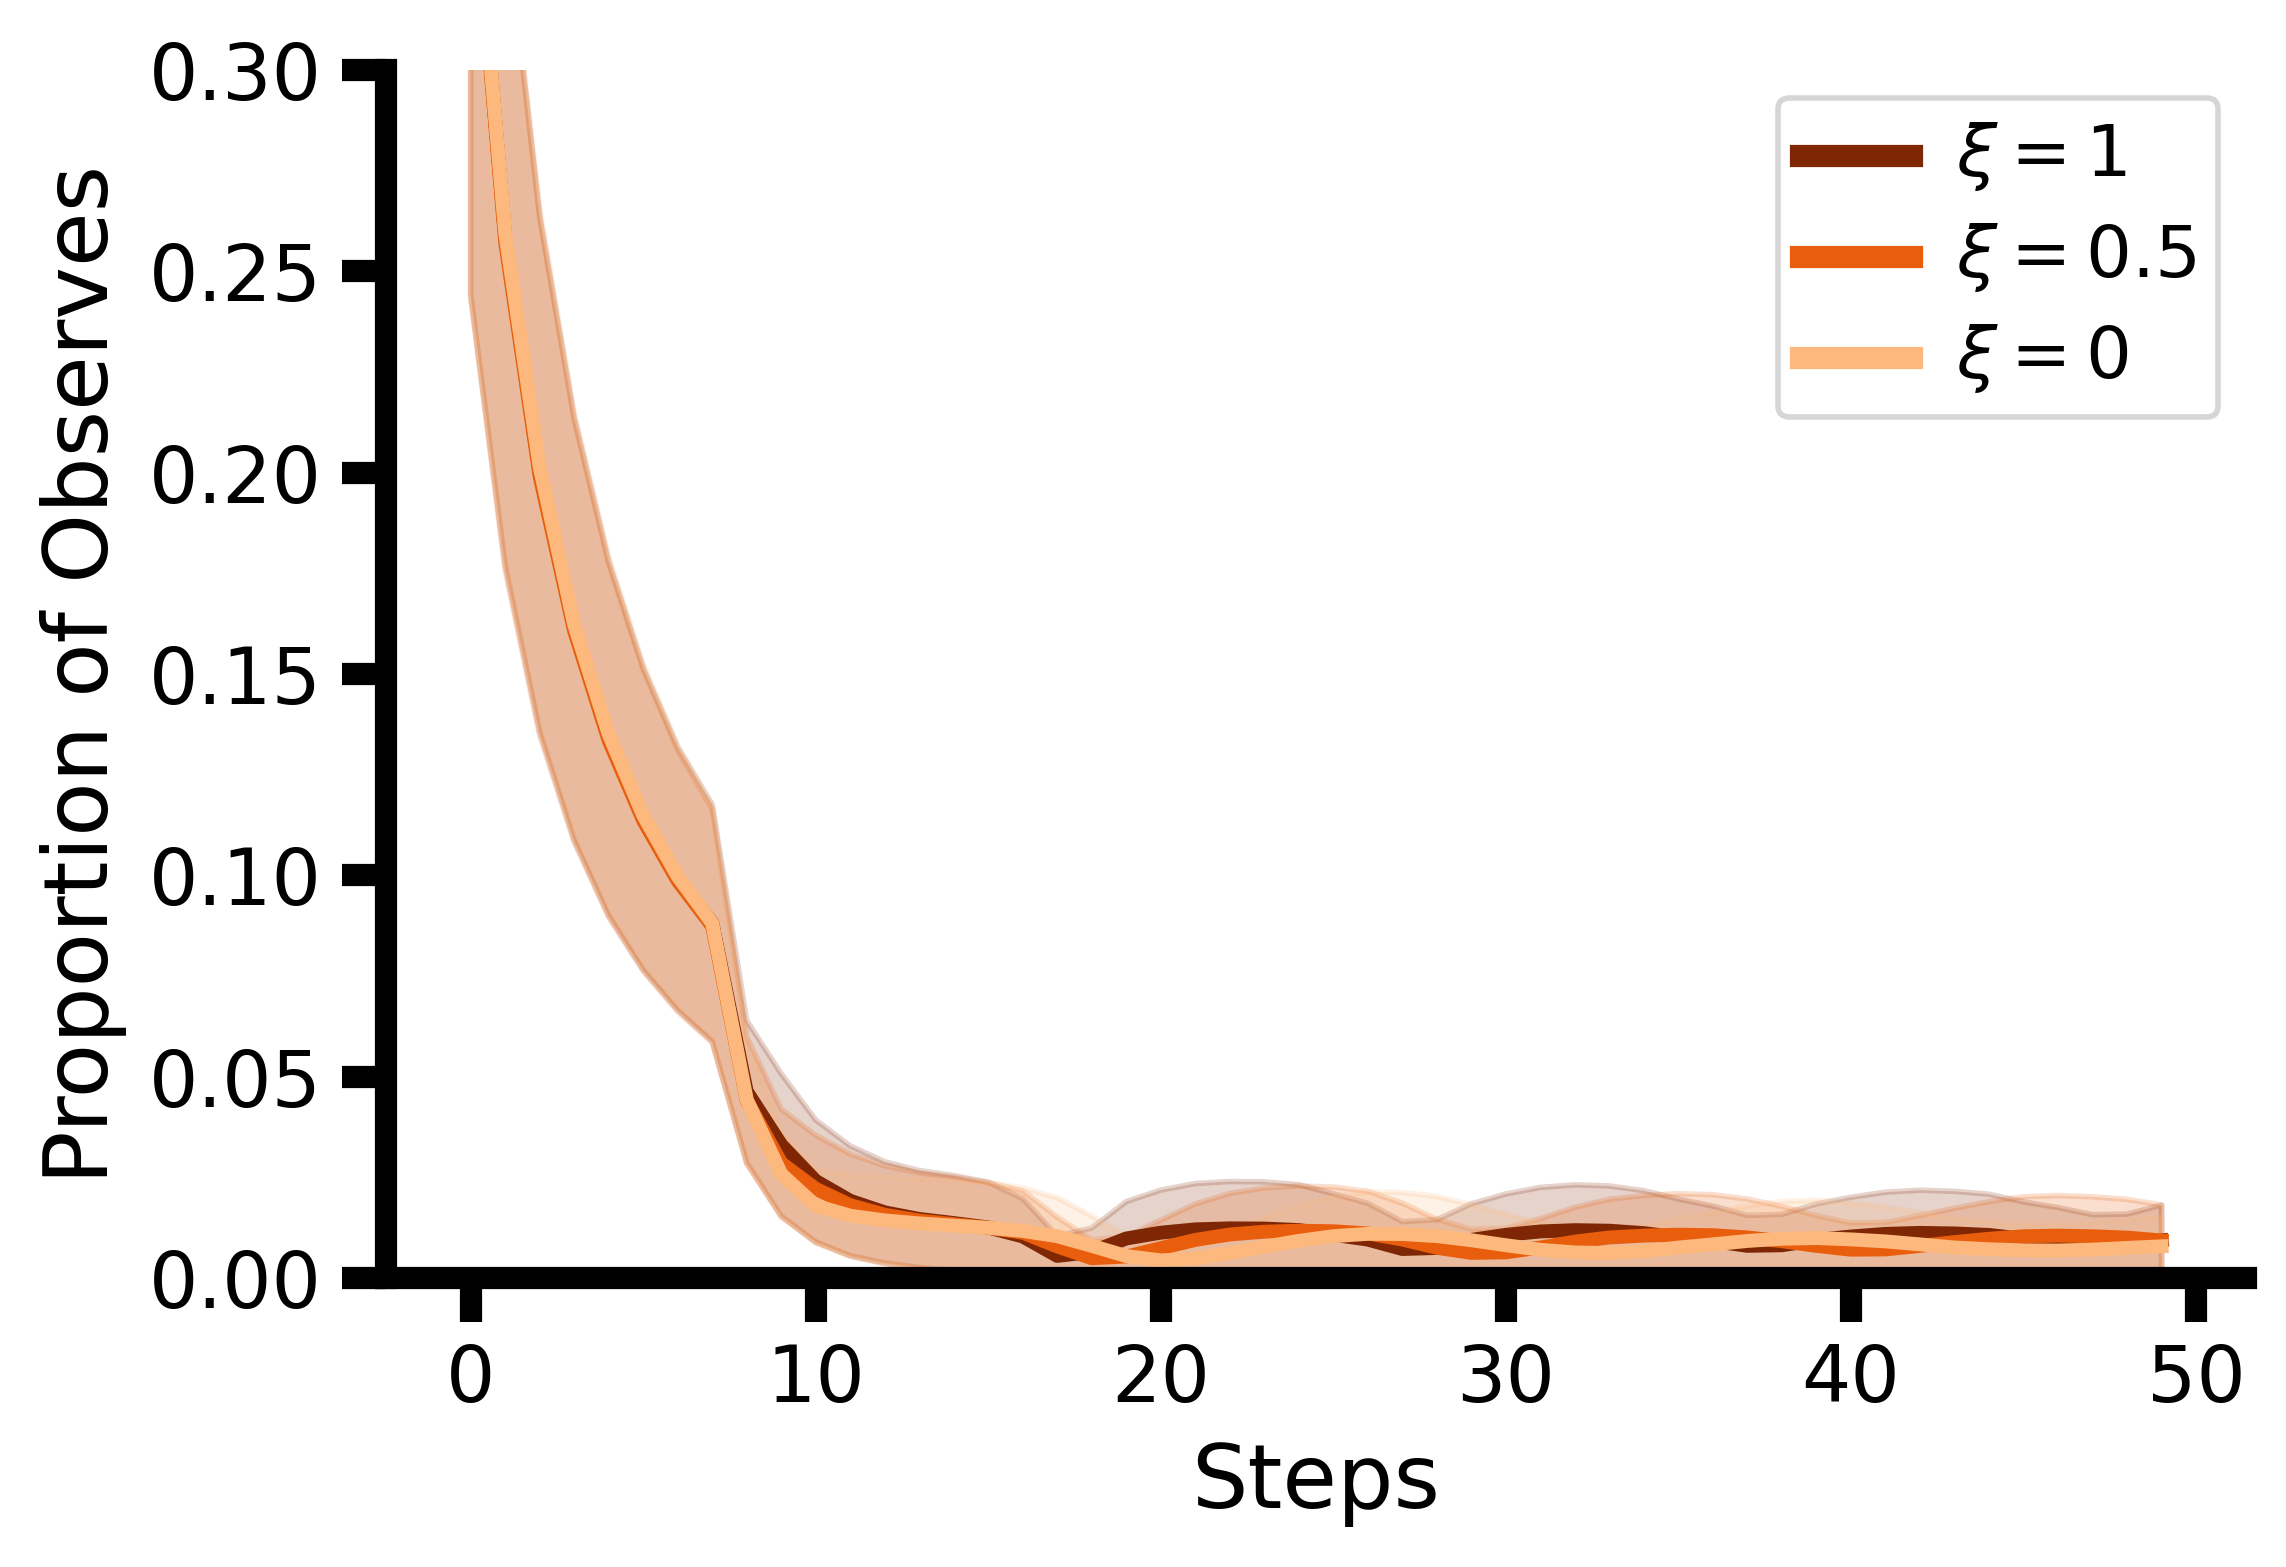

In [34]:
from test_analyses import frac_takes_lineplot

fig = frac_takes_lineplot(taus_to_plot, trajss_logits_taus_control, ylim=ylim, smoothing_window=smoothing_window, cmap = cmap_control, ylabel="Proportion of Observes")

In [35]:
fig.savefig(os.path.join(analysis_folder, 'observes_episode_noape.png'))
fig.savefig(os.path.join(analysis_folder, 'observes_episode_noape.svg'))

## Panel B: Single-Episode Rewards
### General Options

In [40]:
ylim = (0.1, 0.9)
smoothing_window = 8

### Humans

In [41]:
from human_utils_project import get_clean_data, sort_train_test

day = 'day2'

day1_test_mask_cutoff = {
    "groupA": {"lower": 10, "upper": 90},
    "groupB": {"lower": 8, "upper": 72}
}

group = None

df, effs_train, effs_test, test_start = get_clean_data(day = int(day[-1]), exp_date = exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, group=group, file_base=human_data_file_base, exclude_based_on_day3 = False)

cmap_humans = mpl.colormaps['Greens']

/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis/human_utils_project.py:1281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_day3['group'] = False


In [42]:
transitions_train, transitions_test = sort_train_test(df['transitions_ep_rightwrong'], df['effs'], test_start[0])
correct_takes = transitions_test
correct_takes = [correct_takes[:,3], correct_takes[:,2], correct_takes[:,1], correct_takes[:,0]] ## plotting highest efficacy first

## convert observations to np.nans
for correct_take in correct_takes:
    correct_take[correct_take == 0.5] = np.nan

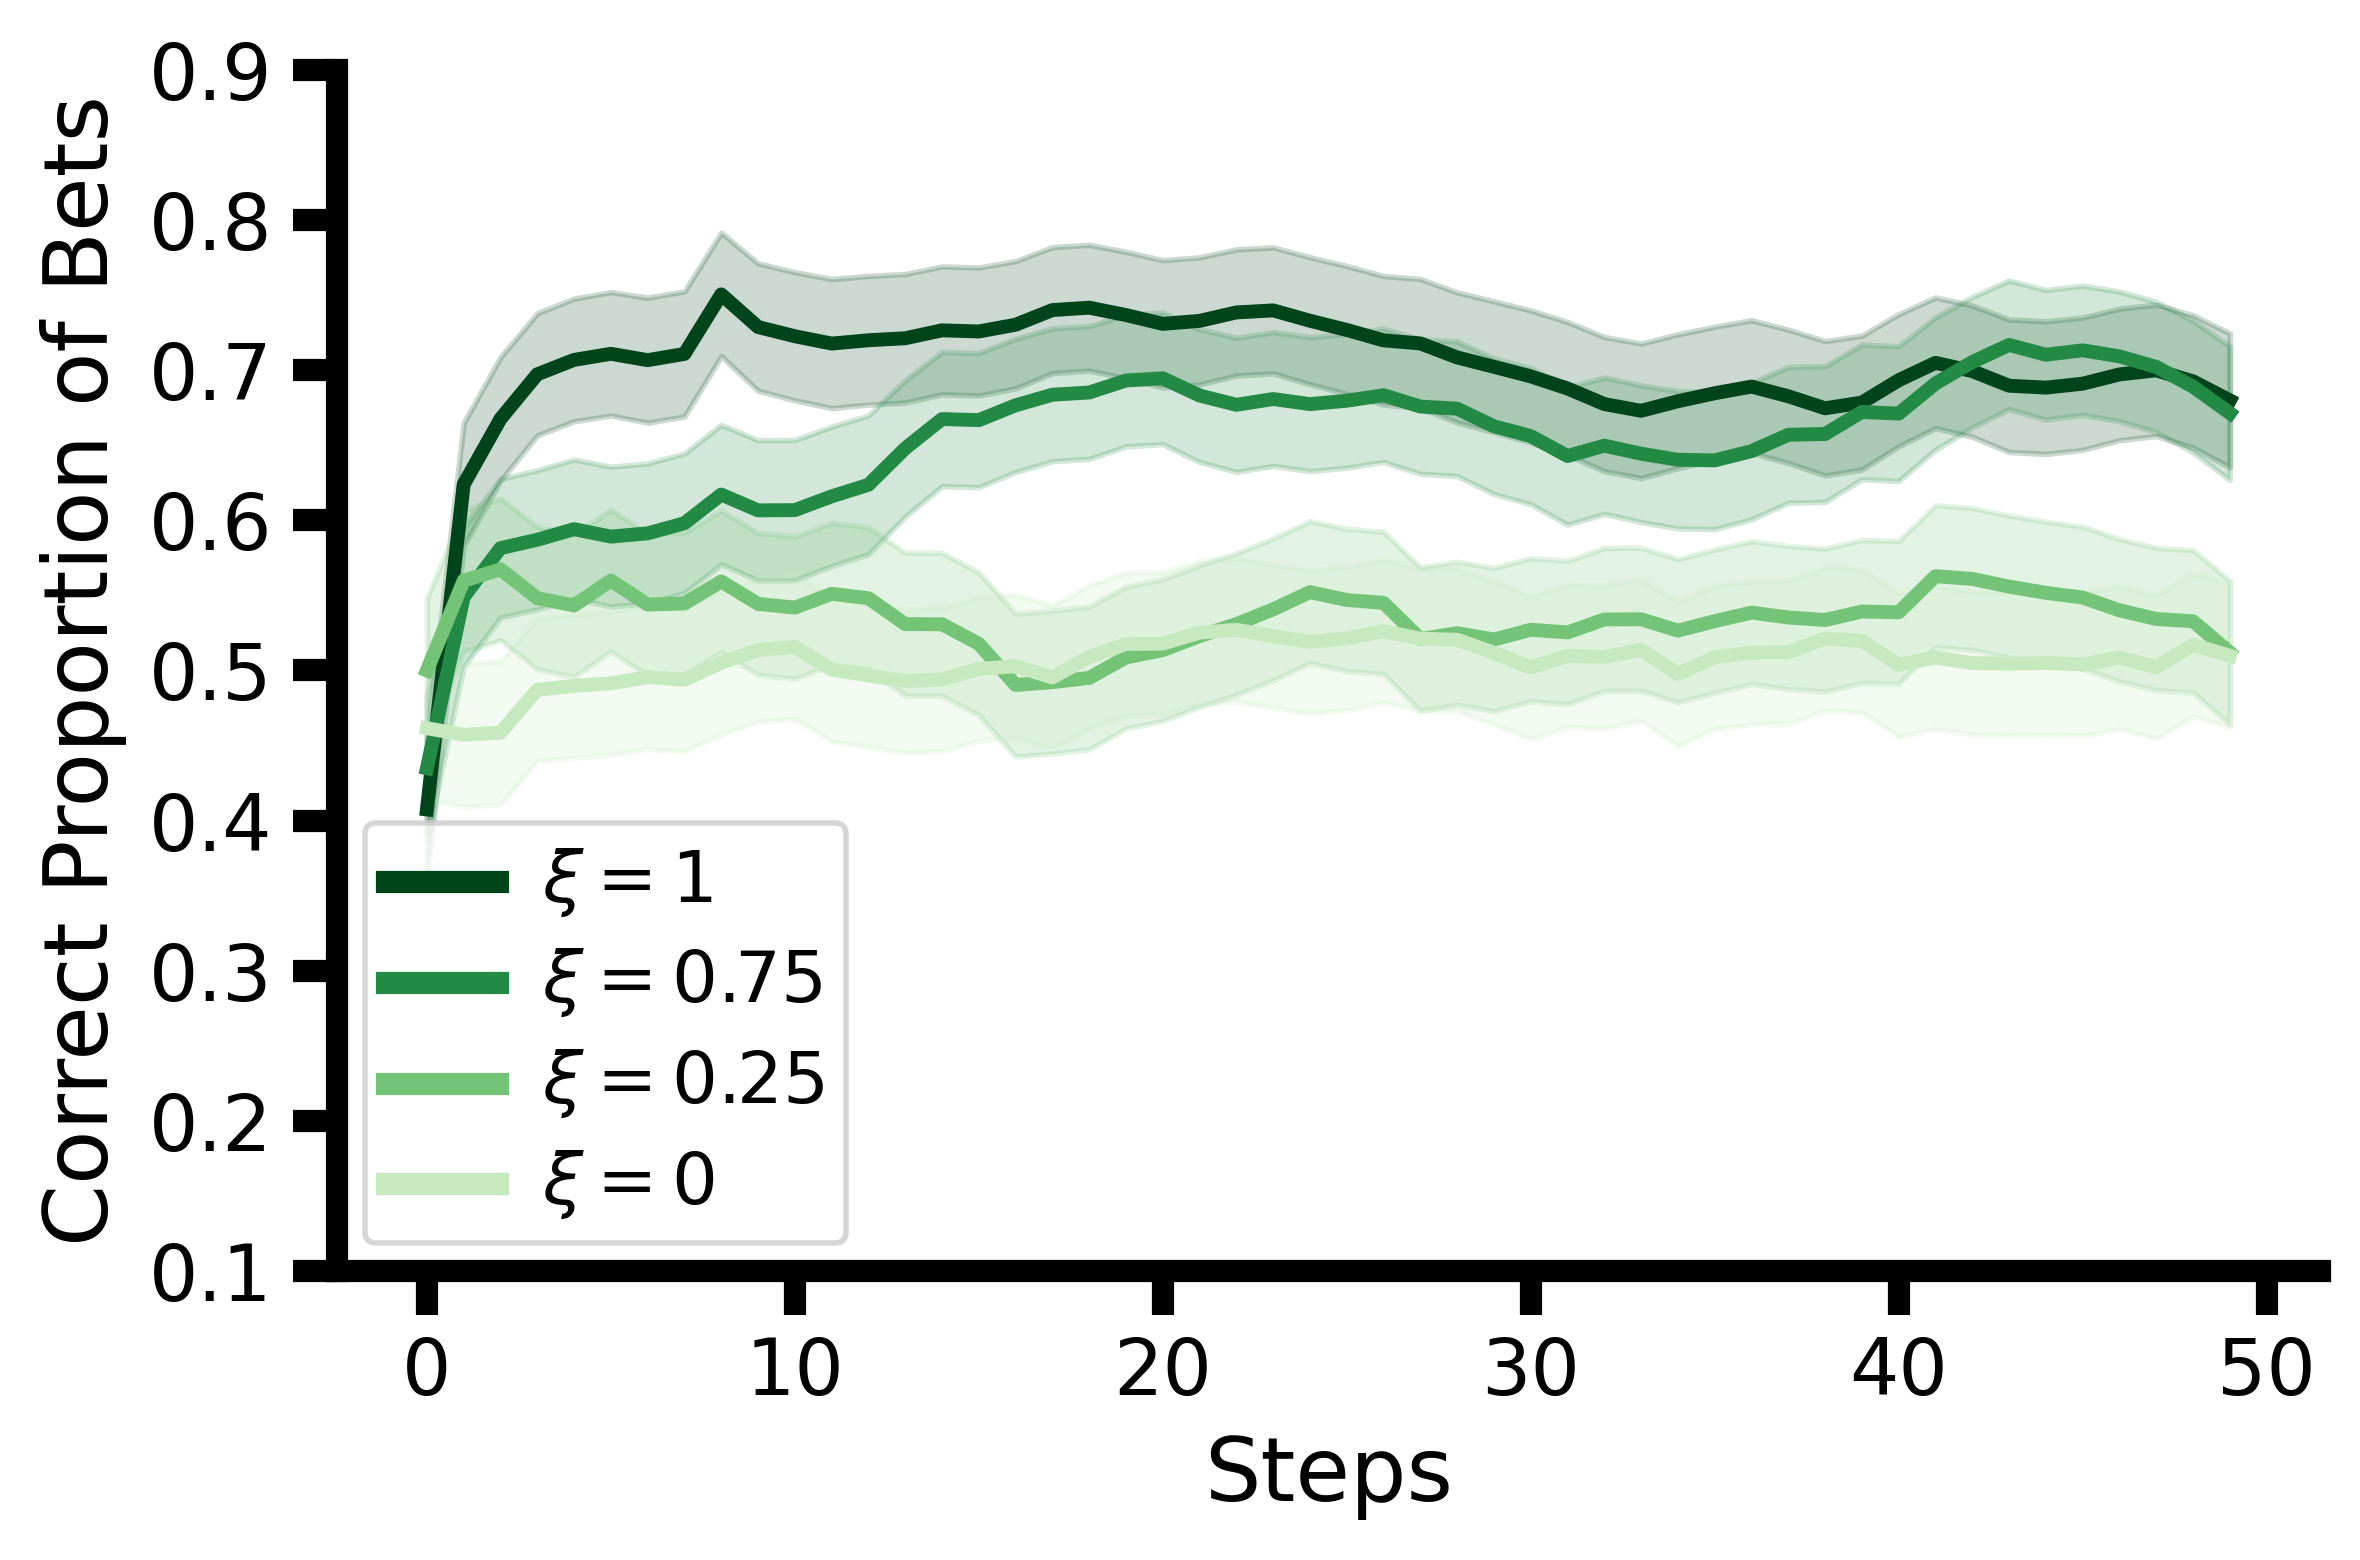

In [43]:
mean_probs = np.array([np.nanmean(correct_take, axis=0) for correct_take in correct_takes])
stderr_probs = np.array([np.nanstd(correct_take, axis=0)/np.sqrt(correct_take.shape[0]) for correct_take in correct_takes])

### smoothing based on rolling average
if smoothing_window > 1:
    mean_probs = pd.DataFrame(mean_probs).apply(lambda x: x.rolling(window=smoothing_window, min_periods=1).mean(), axis=1).values
    stderr_probs = pd.DataFrame(stderr_probs).apply(lambda x: x.rolling(window=smoothing_window, min_periods=1).mean(), axis=1).values

## create figure
fig = plt.figure(dpi=400)
ax = fig.add_subplot(111)

steps = range(mean_probs.shape[1])

for i in range(len(mean_probs)):

    ax.plot(steps, mean_probs[i], label=r"$\xi=$" + str(effs_to_plot[i]), color=cmap_humans((len(mean_probs) - i)/len(mean_probs)))
    ax.fill_between(steps, mean_probs[i] - stderr_probs[i], mean_probs[i] + stderr_probs[i], color=cmap_humans((len(mean_probs) - i)/len(mean_probs)), alpha=0.2)

ax.legend()

ax.set_xlabel("Steps")
ax.set_ylabel("Correct Proportion of Bets")

if ylim is not None:
    ax.set_ylim(ylim)

format_axis(ax)

plt.tight_layout()


In [44]:
fig.savefig(os.path.join(analysis_folder, 'correct_bets_episode_humans.png'))
fig.savefig(os.path.join(analysis_folder, 'correct_bets_episode_humans.svg'))

#### Stats

In [43]:
cropped_takes = [np.nanmean(take[:,15:], axis=1) for take in correct_takes]
plotted_levels = effs_to_plot

In [44]:
## MEANS AND SEMS
for level, takes in zip(plotted_levels, cropped_takes):
    print("Test Controllability ", level)
    print("Mean ", np.nanmean(takes))
    print("StdErr ", np.nanstd(takes)/np.sqrt(len(takes)))
    print("N" , len(takes))

Test Controllability  1
Mean  0.6915165744545817
StdErr  0.02386324226252307
N 60
Test Controllability  0.75
Mean  0.6533890162756054
StdErr  0.020399851233517268
N 60
Test Controllability  0.25
Mean  0.5379008700591505
StdErr  0.013110974916899349
N 60
Test Controllability  0
Mean  0.5208984256382373
StdErr  0.013020240271320215
N 60


In [45]:
## TUKEY'S
groups = flatten([[level]*len(obs) for level, obs in zip(plotted_levels, cropped_takes)])

# Perform Tukey's HSD test
tukey_result = pairwise_tukeyhsd(endog=flatten(cropped_takes), groups=groups, alpha=0.05)

# Print the results
print(tukey_result)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0   0.25    0.017 0.9139 -0.0502 0.0842  False
   0.0   0.75   0.1325    0.0  0.0653 0.1997   True
   0.0    1.0   0.1706    0.0  0.1034 0.2378   True
  0.25   0.75   0.1155 0.0001  0.0483 0.1827   True
  0.25    1.0   0.1536    0.0  0.0864 0.2208   True
  0.75    1.0   0.0381 0.4586 -0.0291 0.1053  False
---------------------------------------------------


In [46]:
from human_utils_behavioral_analysis import fit_mixed_effects_glm

glm = fit_mixed_effects_glm(df, 'n_observes')
glm.summary()


<class 'statsmodels.iolib.summary2.Summary'>
"""
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    n_observes
No. Observations:    540        Method:                REML      
No. Groups:          60         Scale:                 4.7309    
Min. group size:     9          Log-Likelihood:        -1260.6254
Max. group size:     9          Converged:             Yes       
Mean group size:     9.0                                         
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               3.833    0.431  8.894 0.000  2.989  4.678
C(efficacy_C)[T.0.125] -0.100    0.397 -0.252 0.801 -0.878  0.678
C(efficacy_C)[T.0.25]   1.250    0.397  3.148 0.002  0.472  2.028
C(efficacy_C)[T.0.375]  1.050    0.397  2.644 0.008  0.272  1.828
C(efficacy_C)[T.0.5]    2.150    0.397  5.414 0.000  1.372  2.928
C(efficacy_C)[T.0.625]  2.517    0.397  6.337 0.000  1.738  3.295
C(efficacy_C)[T.0.75]   2.683    0.397  6.757 0.000  1.905  3.462
C(efficacy_C)[T.0.875]  3.200    0.397  8.058 0.000  2.422  3.978
C(efficacy_C)[T.1.0]    2.467    0.397  6.212 0.000  1.688  3.245
Group Var               6.415    0.623                           
=================================================================

"""

### APE-trained Neural Networks

In [47]:
from settings_anal import pepe_human_ape_models as ape_models
from utils_project import load_modelrun_files
from settings_anal import pepe_human_ape_traj_timestamp as traj_timestamp

traj_base = os.path.join('data', 'eval', 'pepe', )

cmap_apes = mpl.colormaps['Blues']
taus_to_plot = [0, 0.5, 1]

rewss_taus_ape, counterss_peeks_taus_ape, control_errss_taus_ape, trajss_actions_taus_ape, trajss_logits_taus_ape, trajss_ps_taus_ape = load_modelrun_files(ape_models, traj_timestamp, ape=True, traj_base=traj_base)

## select only the taus to plot
trajss_logits_taus_ape = np.array(trajss_logits_taus_ape)
trajss_logits_taus_ape = trajss_logits_taus_ape[:, ::4]

trajss_ps_taus_ape = np.array(trajss_ps_taus_ape)
trajss_ps_taus_ape = trajss_ps_taus_ape[:, ::4]

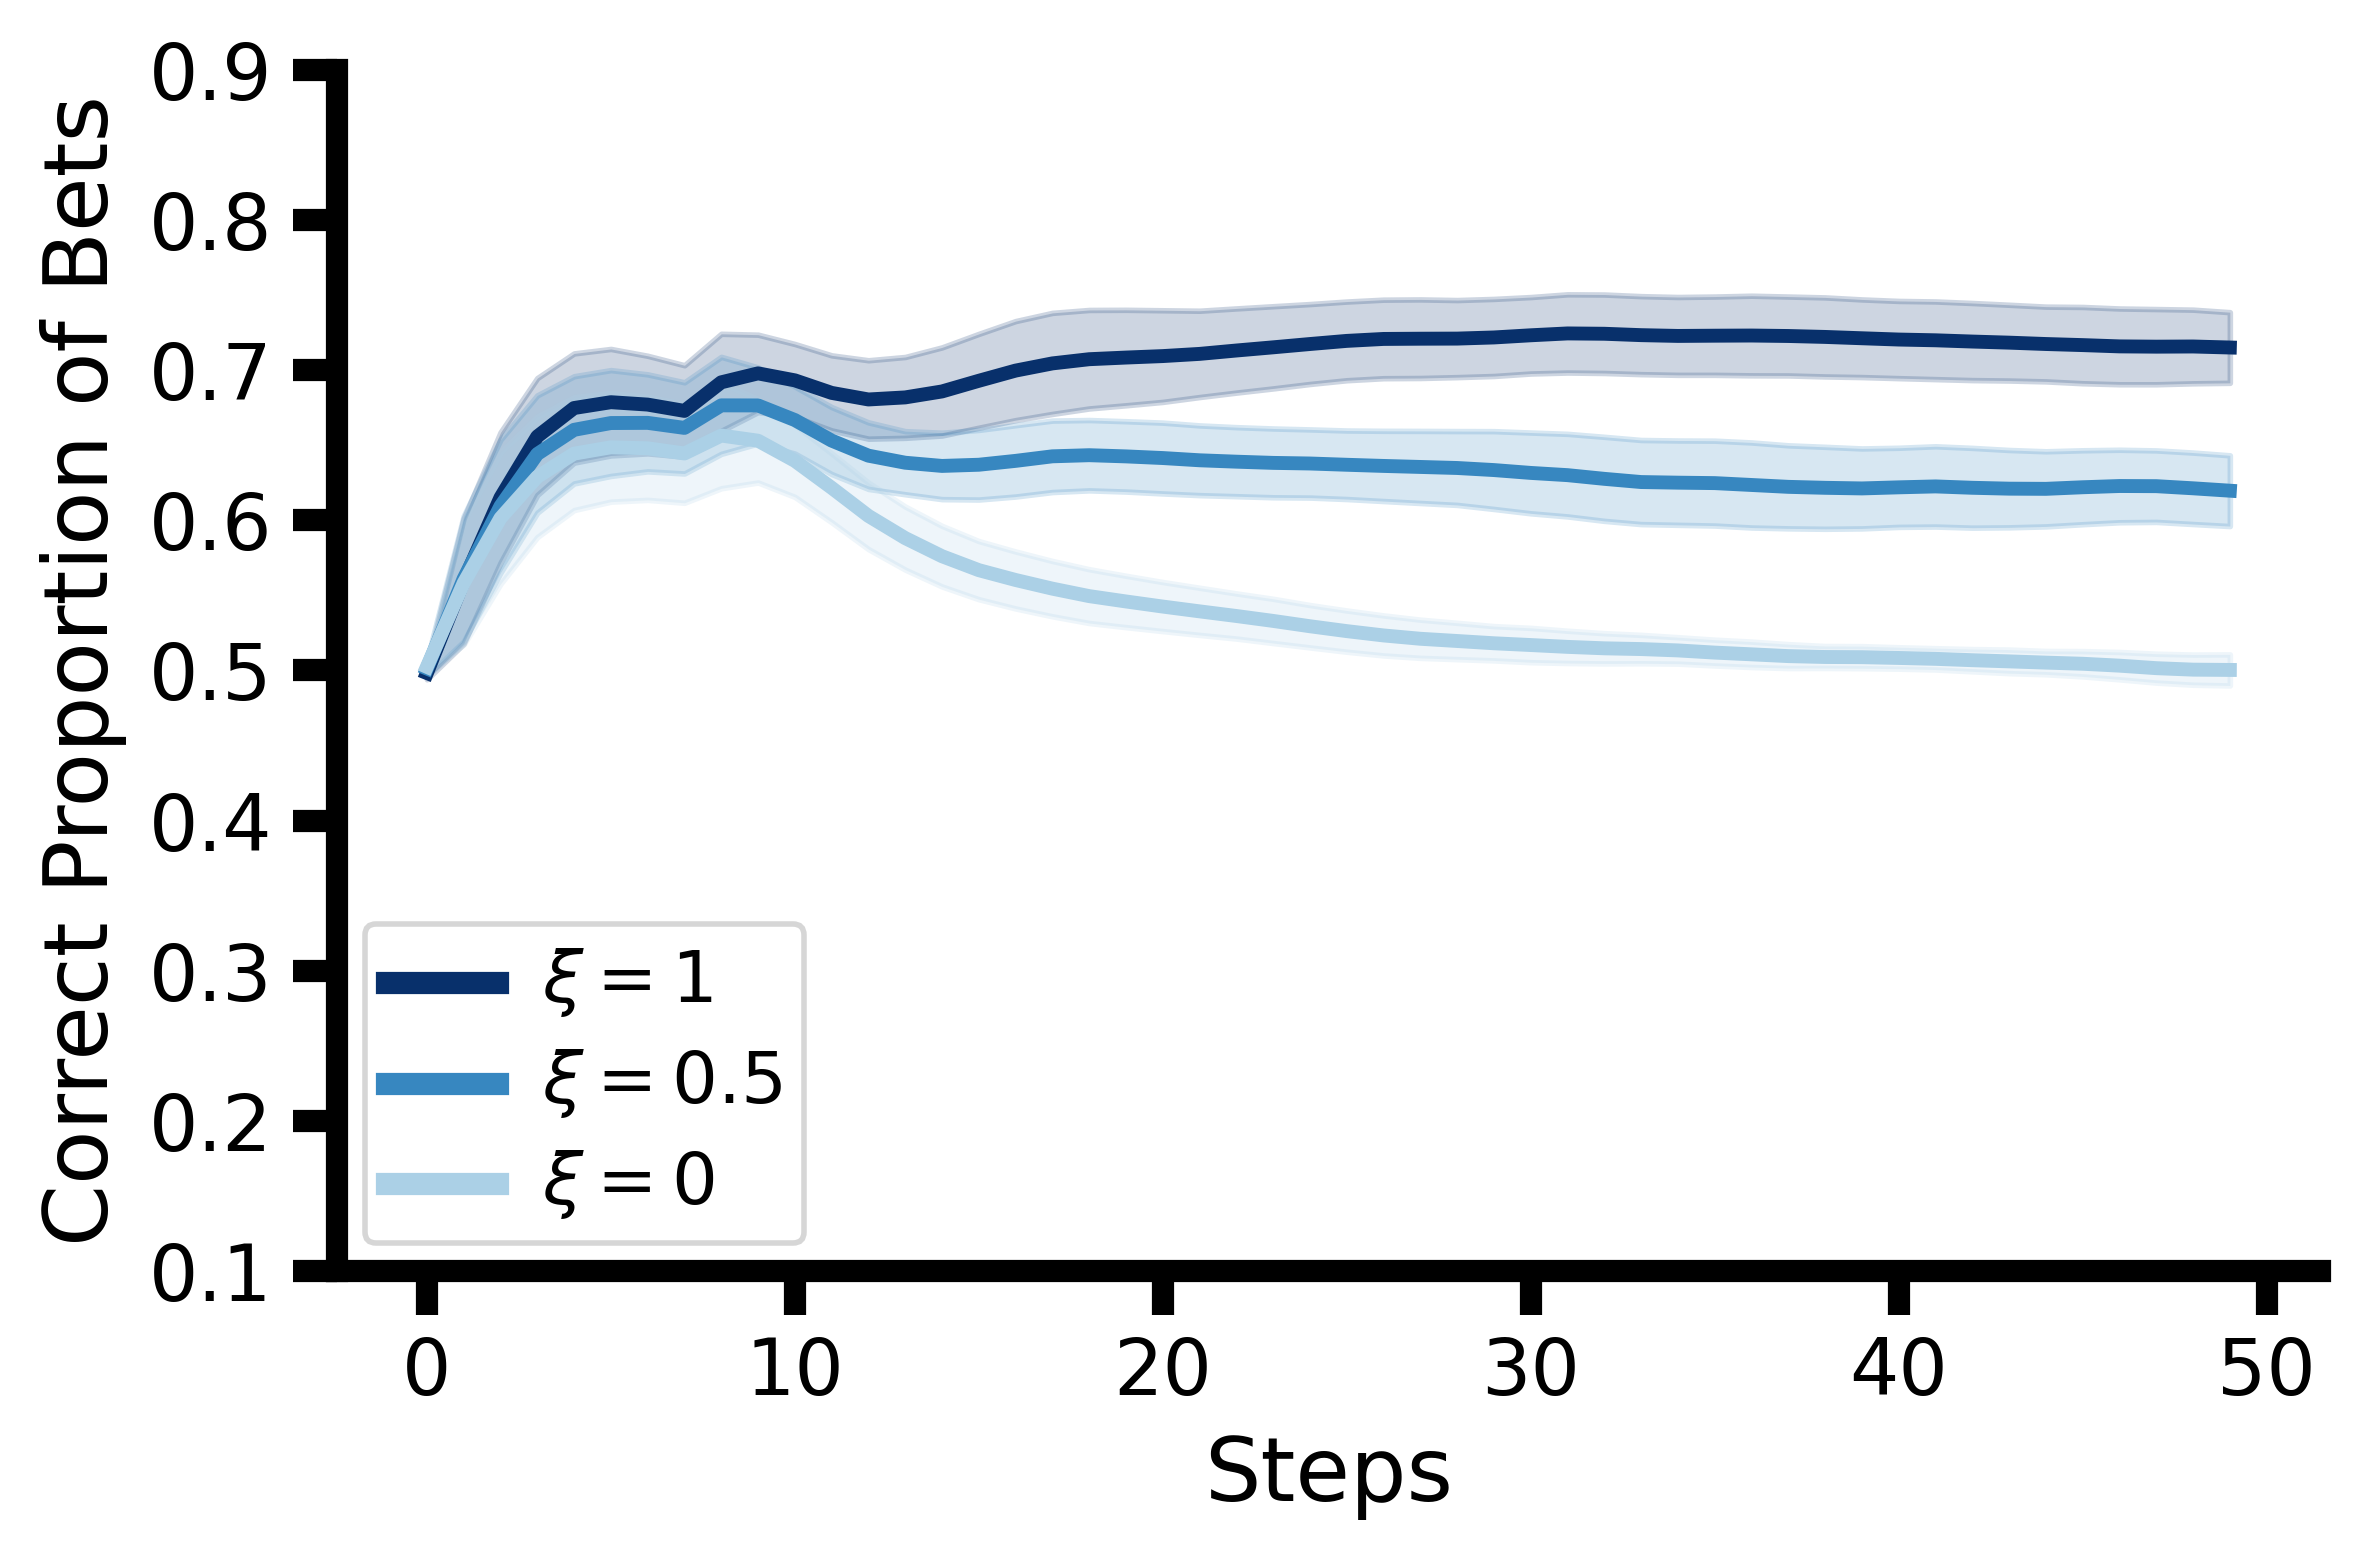

In [48]:
from test_analyses import frac_correct_takes_lineplot

fig = frac_correct_takes_lineplot(taus_to_plot, trajss_logits_taus_ape, trajss_ps_taus_ape, ylim=ylim, smoothing_window=smoothing_window, cmap = cmap_apes, ylabel="Correct Proportion of Bets")

In [49]:
fig.savefig(os.path.join(analysis_folder, 'correct_bets_episode_apes.png'))
fig.savefig(os.path.join(analysis_folder, 'correct_bets_episode_apes.svg'))

### No-APE Networks

In [51]:
from settings_anal import pepe_human_control_models as control_models
from utils_project import load_modelrun_files
from settings_anal import pepe_human_control_traj_timestamp as traj_timestamp

traj_base = os.path.join('data', 'eval', 'pepe', )

cmap_control = mpl.colormaps['Oranges']
taus_to_plot = [0, 0.5, 1]

rewss_taus_control, counterss_peeks_taus_control, _, trajss_actions_taus_control, trajss_logits_taus_control, trajss_ps_taus_control = load_modelrun_files(control_models, traj_timestamp, ape=False, traj_base=traj_base)

## select only the taus to plot
trajss_logits_taus_control = np.array(trajss_logits_taus_control)
trajss_logits_taus_control = trajss_logits_taus_control[:, ::4]

trajss_ps_taus_control = np.array(trajss_ps_taus_control)
trajss_ps_taus_control = trajss_ps_taus_control[:, ::4]

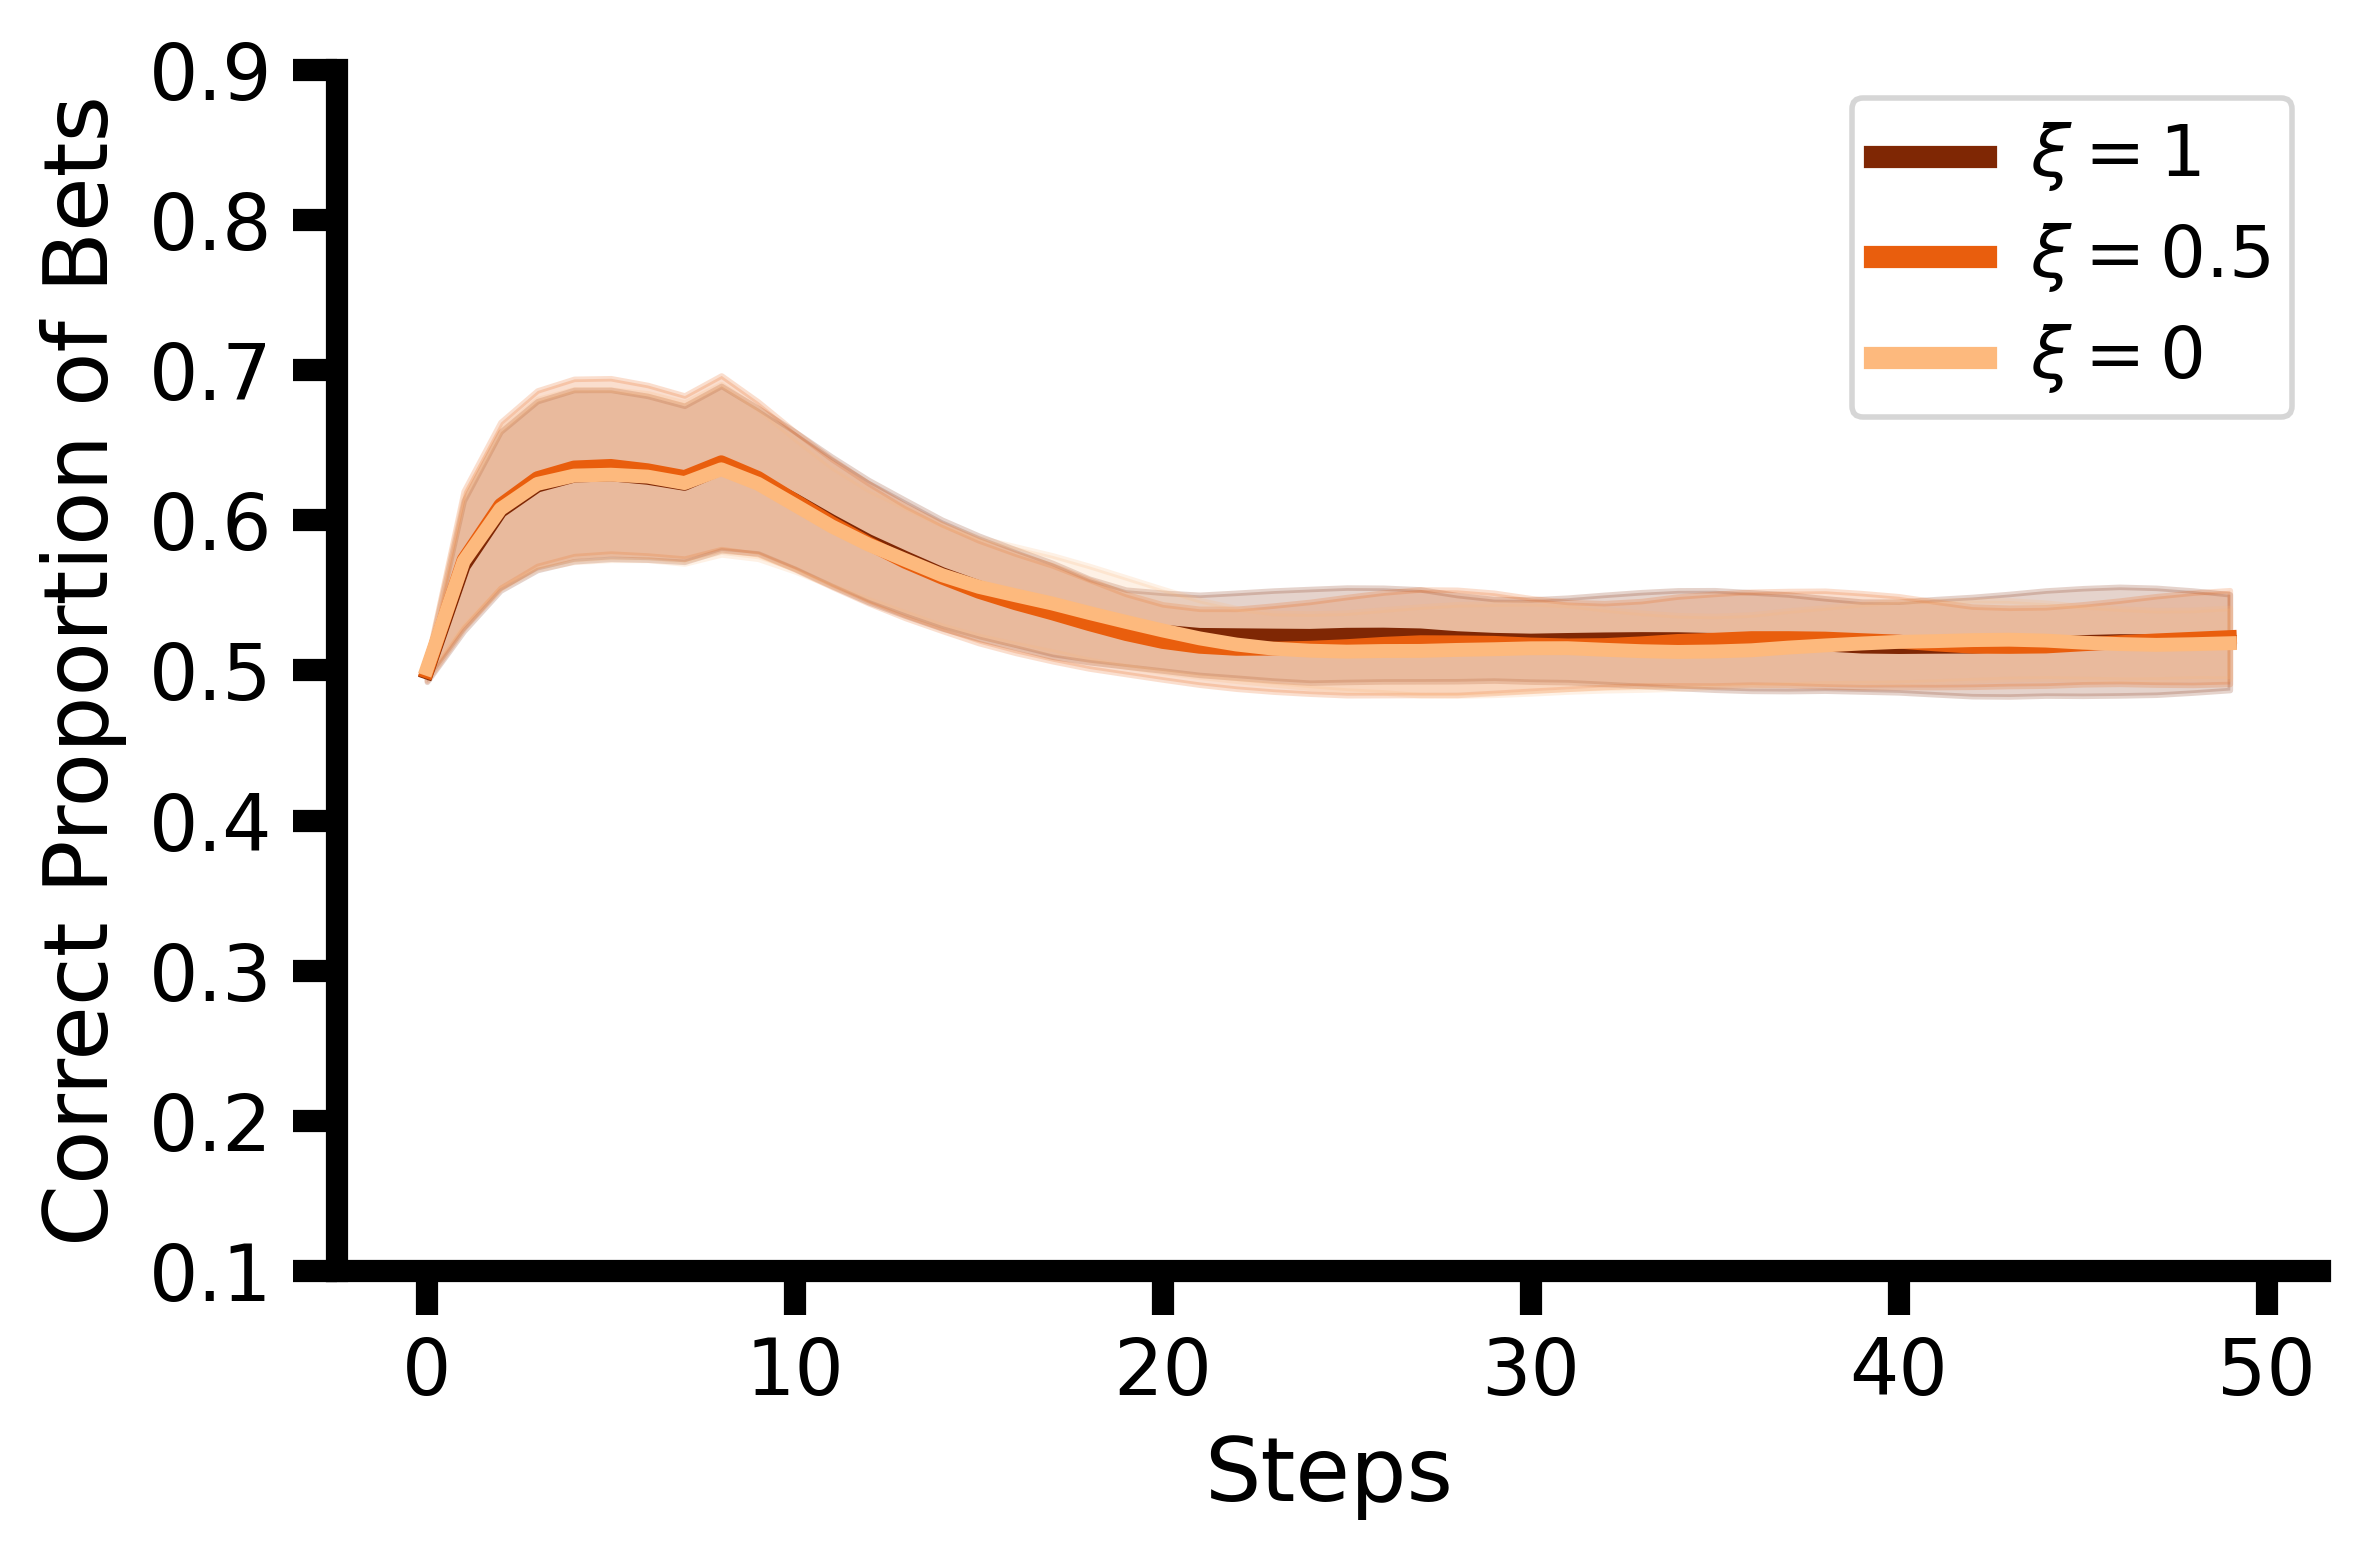

In [52]:
from test_analyses import frac_correct_takes_lineplot

fig = frac_correct_takes_lineplot(taus_to_plot, trajss_logits_taus_control, trajss_ps_taus_control, ylim=ylim, smoothing_window=smoothing_window, cmap = cmap_control, ylabel="Correct Proportion of Bets")

In [53]:
fig.savefig(os.path.join(analysis_folder, 'correct_bets_episode_noape.png'))
fig.savefig(os.path.join(analysis_folder, 'correct_bets_episode_noape.svg'))

## Panel C: Across-Efficacy Observations
### General Options

In [45]:
ylim = (-1.25,25.5)

### Humans

In [46]:
from human_utils_project import get_clean_data, sort_train_test

day = 'day2'

day1_test_mask_cutoff = {
    "groupA": {"lower": 10, "upper": 90},
    "groupB": {"lower": 8, "upper": 72}
}

human_data_file_base = '/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis'

group = None

df, effs_train, effs_test, test_start = get_clean_data(day = int(day[-1]), exp_date = exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, group=group, file_base=human_data_file_base, exclude_based_on_day3 = False)

cmap_humans = mpl.colormaps['Greens']

/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis/human_utils_project.py:1281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_day3['group'] = False


In [47]:
n_trainA, n_testA = sort_train_test(df['n_observes'], df['effs'], test_start[0])

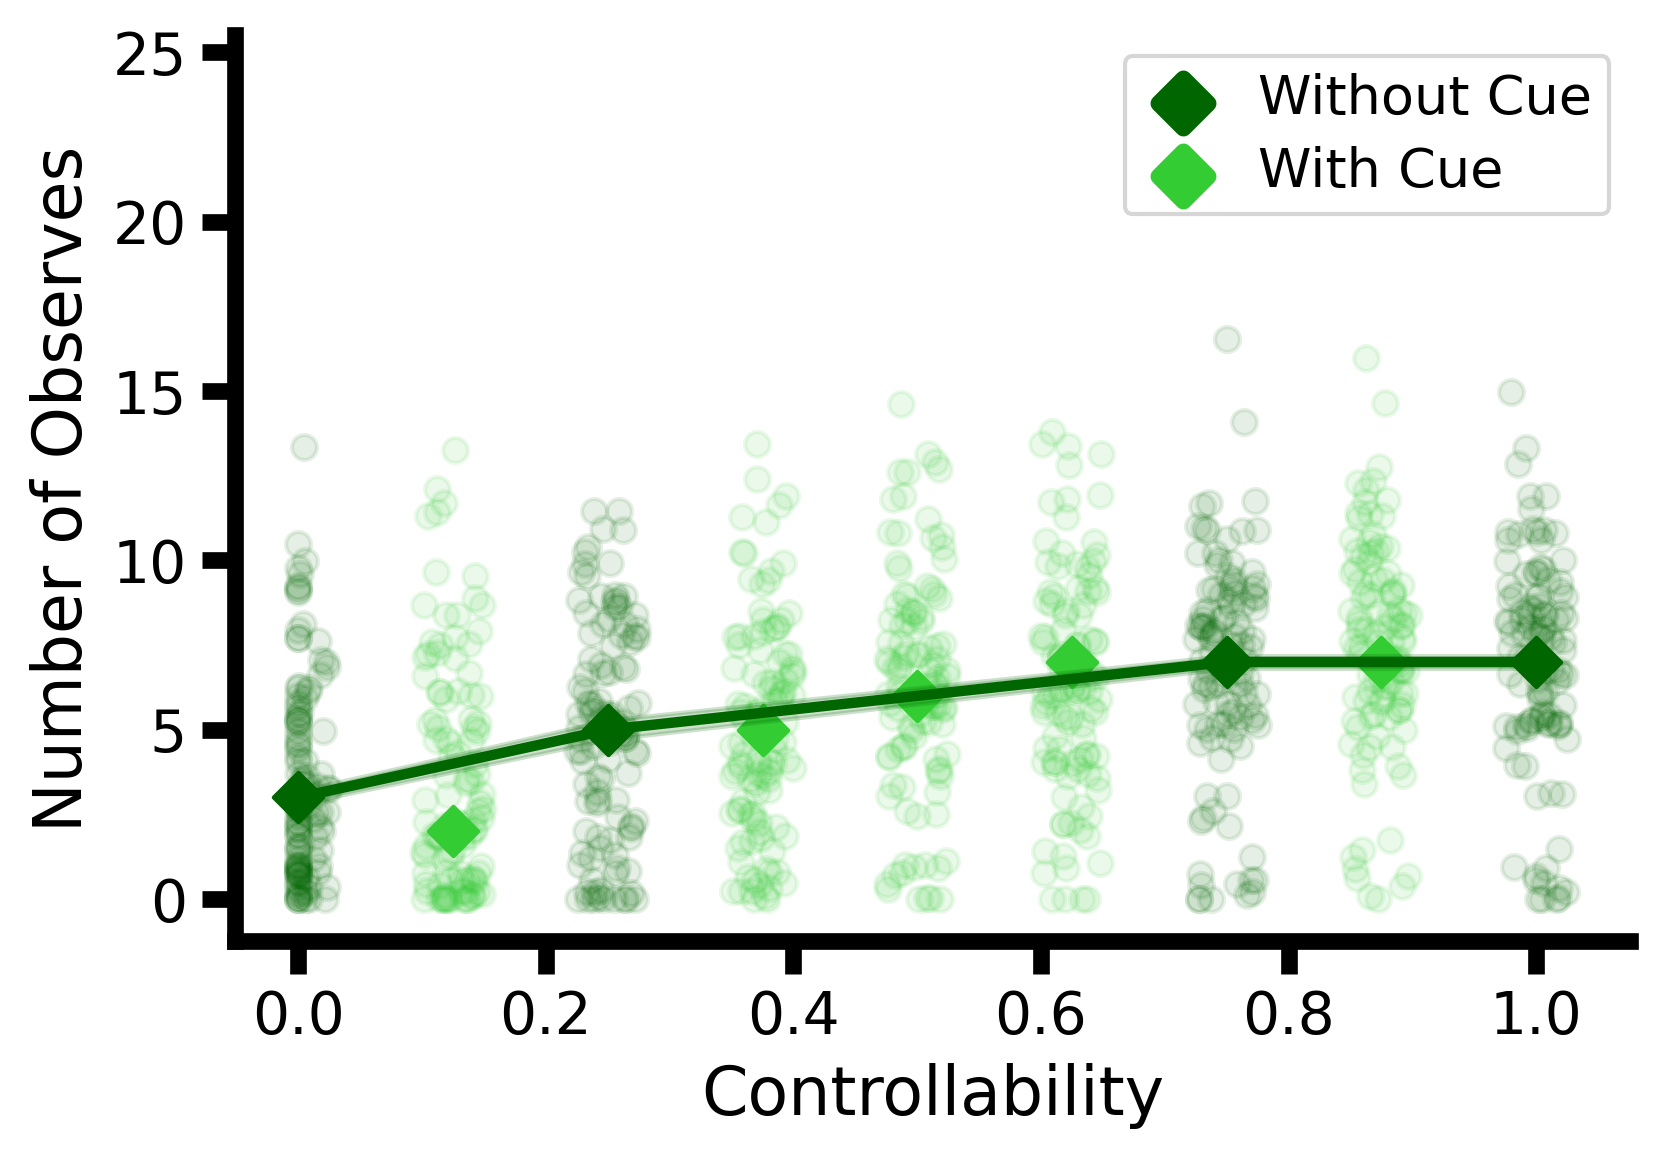

In [48]:
from human_plot_traj_analyses import plot_line_scatter_group
    
fig = plot_line_scatter_group([n_testA], [effs_test[0]], [n_trainA], [effs_train[0]], ylabel='Number of Observes', xjitter=0.025, yjitter=1, median_over_mean=True, ylim=ylim, xlabel="Controllability")

In [49]:
fig.savefig(os.path.join(analysis_folder, 'observes_across_humans.png'))
fig.savefig(os.path.join(analysis_folder, 'observes_across_humans.svg'))

### APE-trained neural networks

In [ ]:
from settings_anal import pepe_human_ape_models as ape_models
from utils_project import load_modelrun_files
from settings_anal import pepe_human_ape_traj_timestamp as traj_timestamp

traj_base = os.path.join('data', 'eval', 'pepe', )

cmap_apes = mpl.colormaps['Blues']
test_taus = np.arange(0, 1.1, 0.125)

rewss_taus_ape, counterss_peeks_taus_ape, control_errss_taus_ape, trajss_actions_taus_ape, trajss_logits_taus_ape, trajss_ps_taus_ape = load_modelrun_files(ape_models, traj_timestamp, ape=True, traj_base=traj_base)

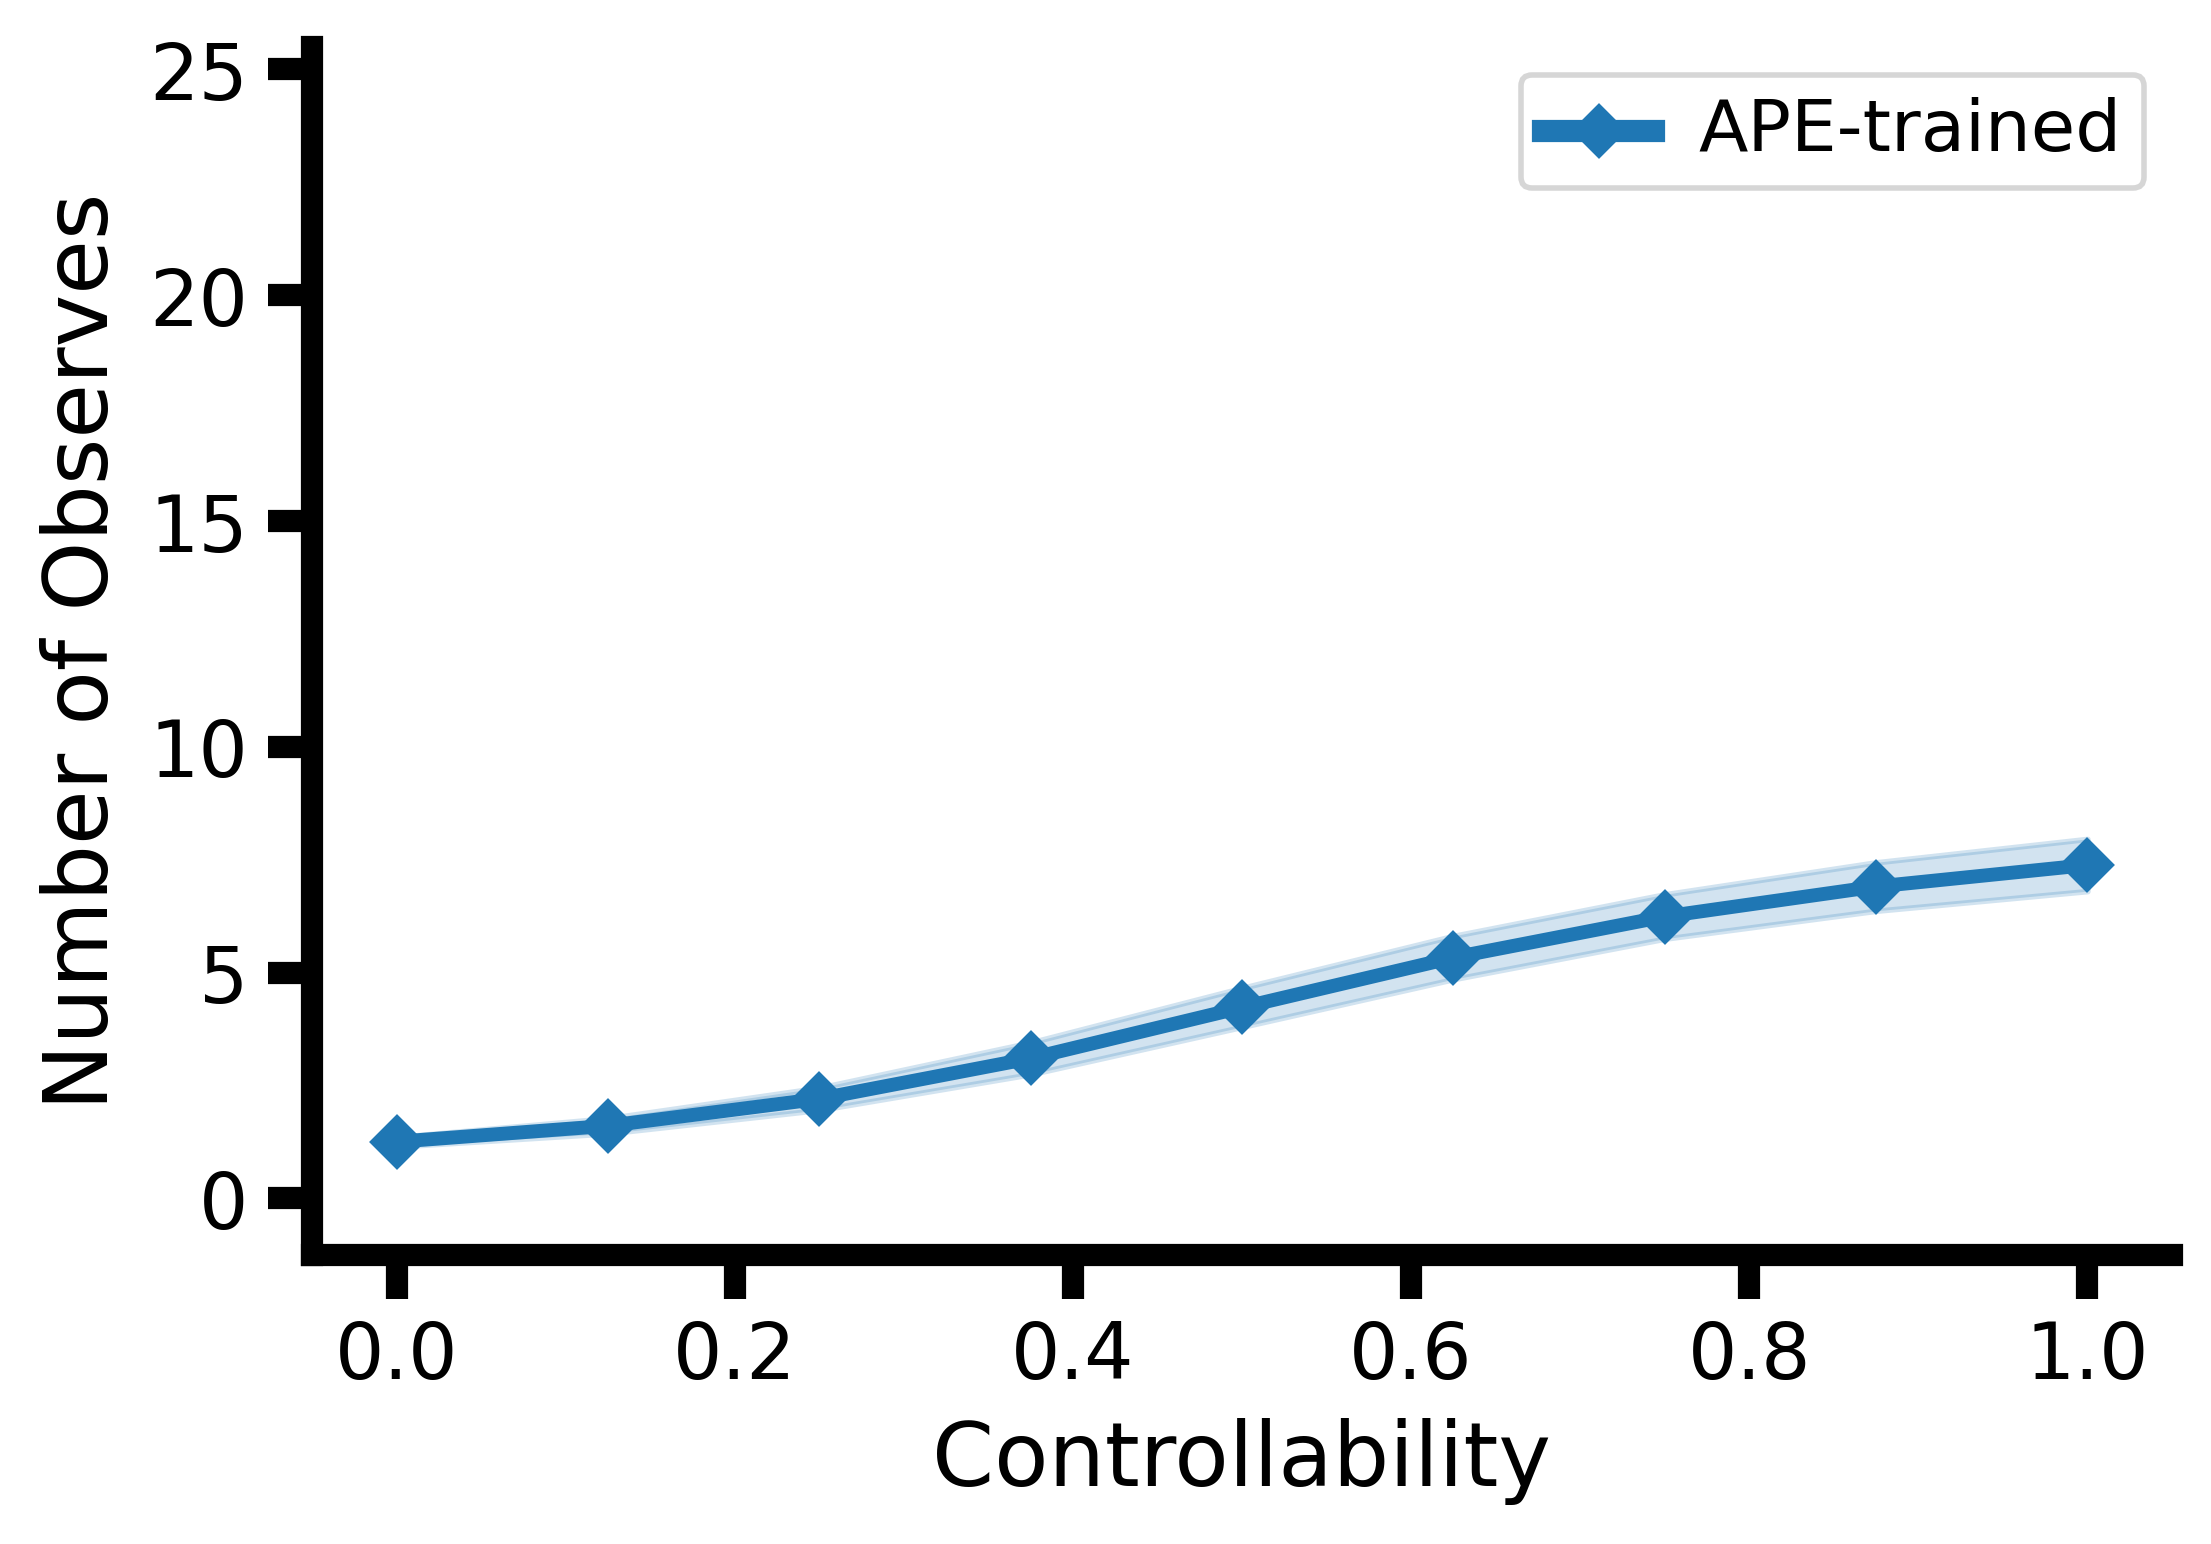

In [ ]:
from test_analyses import plot_comparison_curves_several_runs

fig = plot_comparison_curves_several_runs(test_taus, list(reversed(counterss_peeks_taus_ape)), axis_xlabel='Controllability', axis_ylabel='Number of Observes', label_exp='APE-trained', label_control='no APE', ylim=ylim, marker='D')

In [ ]:
fig.savefig(os.path.join(analysis_folder, 'observes_across_ape.png'))
fig.savefig(os.path.join(analysis_folder, 'observes_across_ape.svg'))

### No-APE Networks

In [ ]:
from settings_anal import pepe_human_control_models as control_models
from utils_project import load_modelrun_files
from settings_anal import pepe_human_control_traj_timestamp as traj_timestamp

traj_base = os.path.join('data', 'eval', 'pepe', )

cmap_control = mpl.colormaps['Oranges']
taus_to_plot = [0, 0.5, 1]

rewss_taus_control, counterss_peeks_taus_control, _, trajss_actions_taus_control, trajss_logits_taus_control, trajss_ps_taus_control = load_modelrun_files(control_models, traj_timestamp, ape=False, traj_base=traj_base)

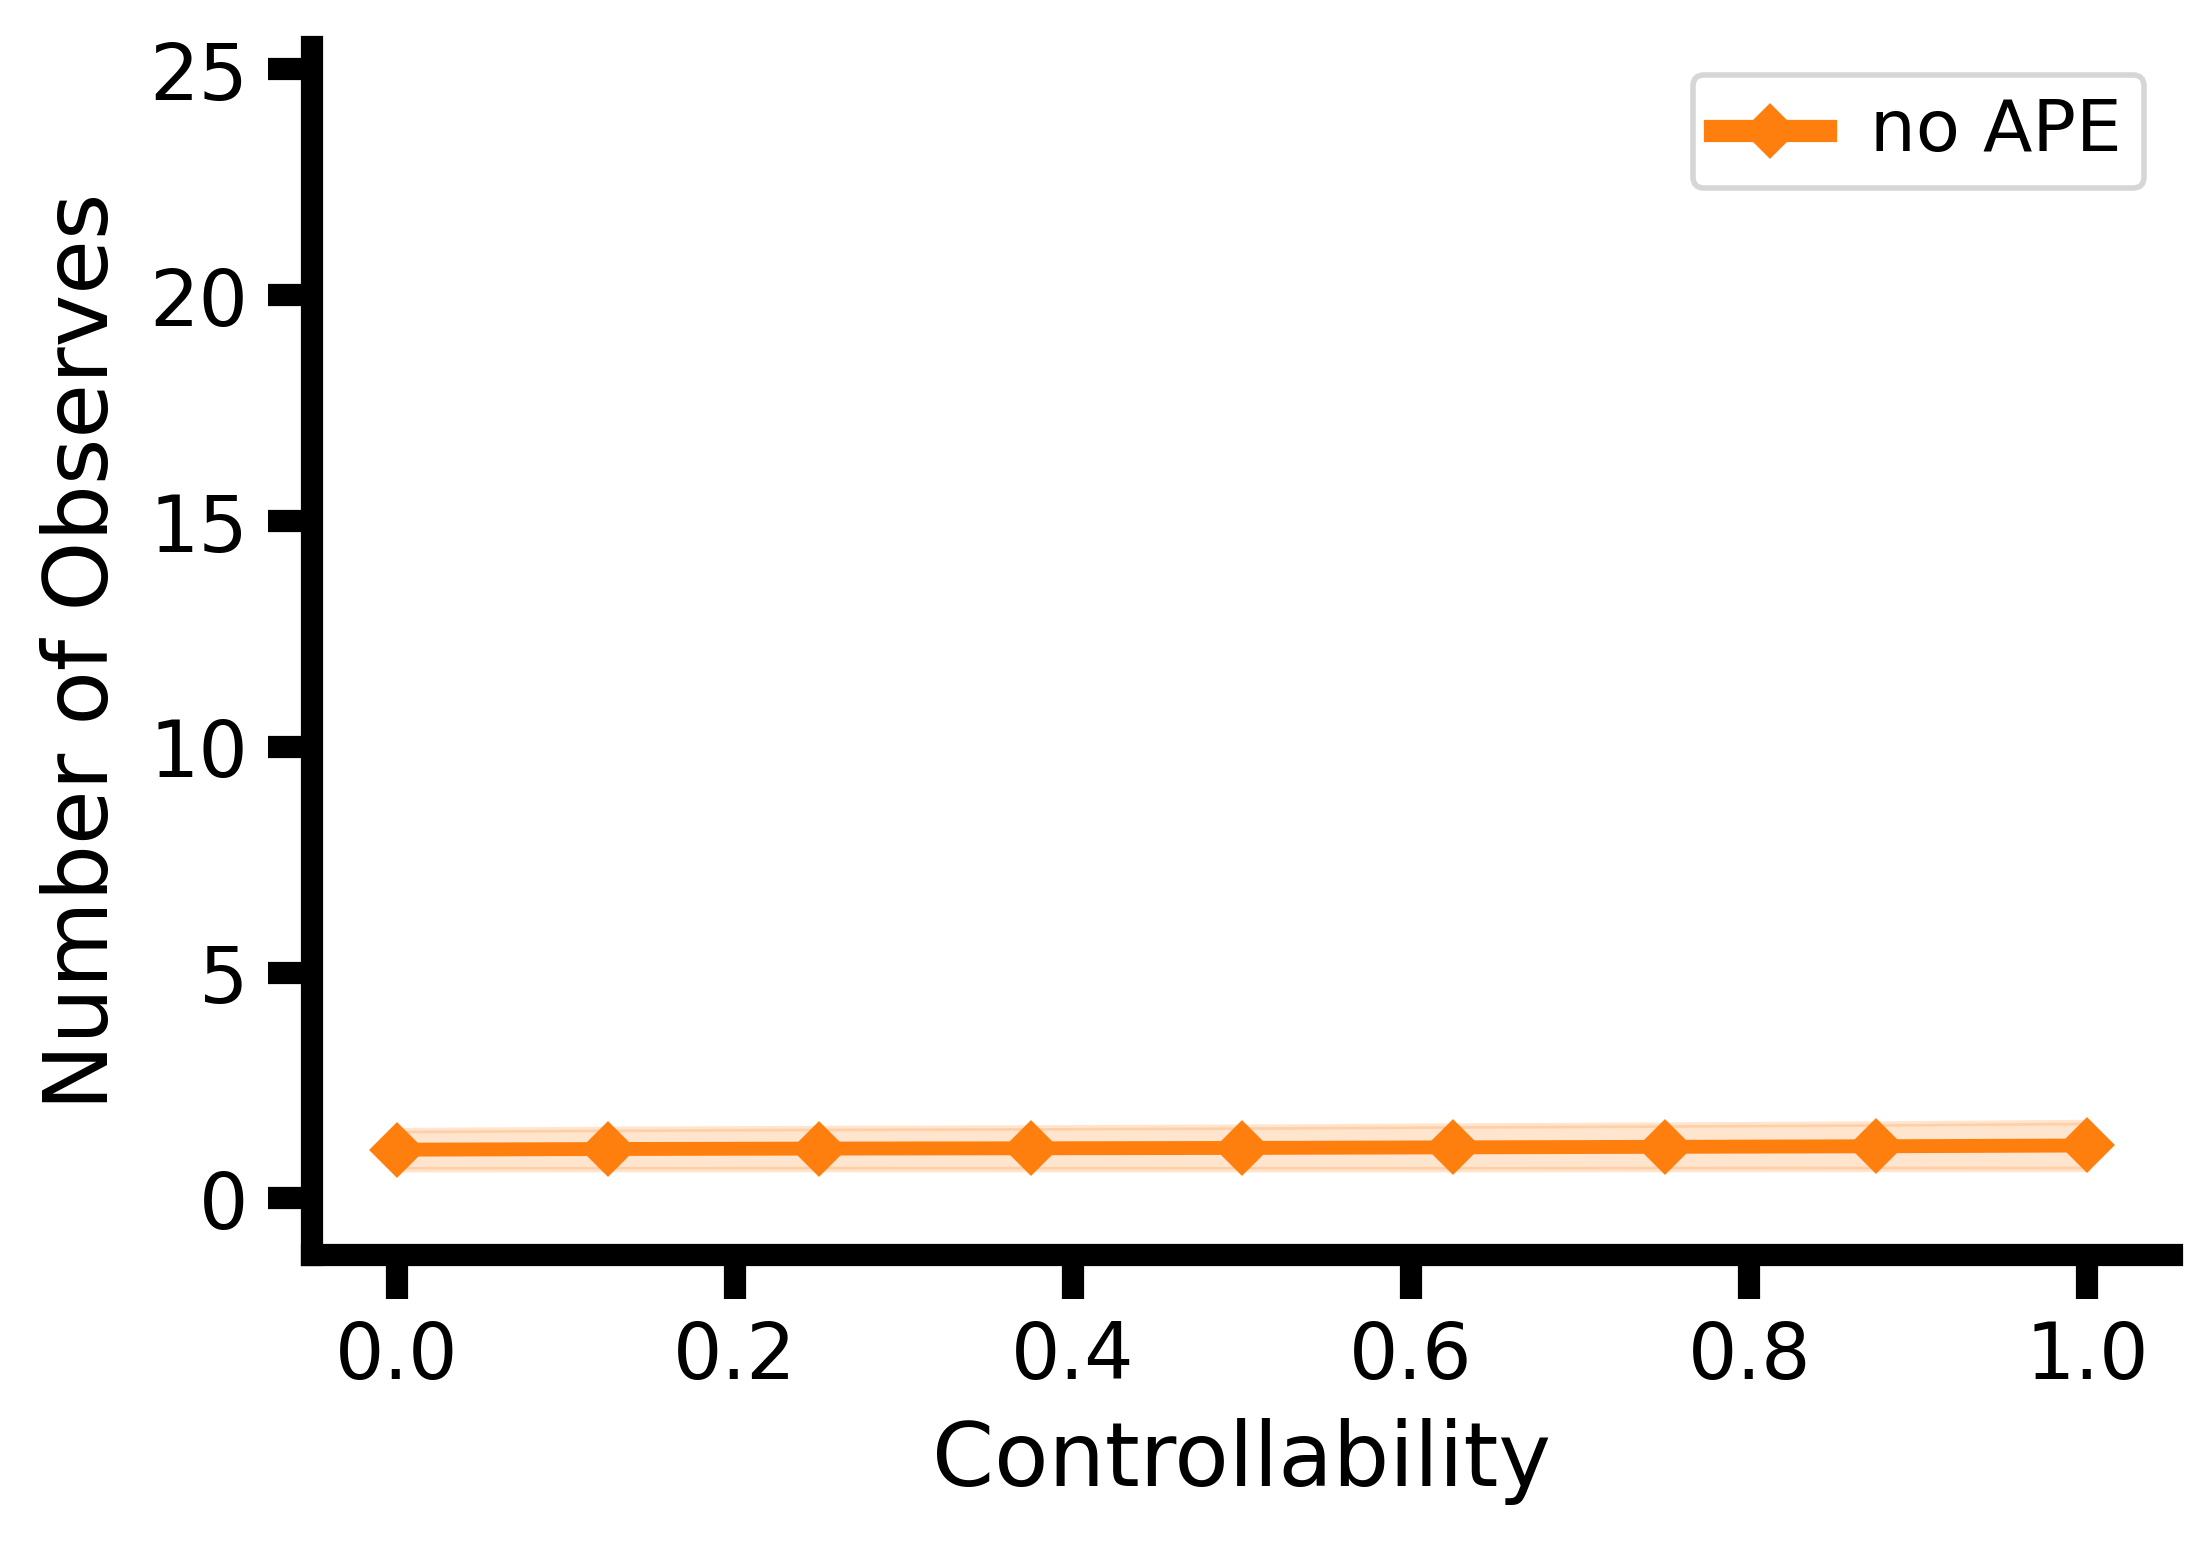

In [ ]:
from test_analyses import plot_comparison_curves_several_runs

fig = plot_comparison_curves_several_runs(x_control=test_taus, y_control=list(reversed(counterss_peeks_taus_control)), axis_xlabel='Controllability', axis_ylabel='Number of Observes', label_exp='APE-trained', label_control='no APE', ylim=ylim, marker='D')

In [ ]:
fig.savefig(os.path.join(analysis_folder, 'observes_across_noape.png'))
fig.savefig(os.path.join(analysis_folder, 'observes_across_noape.svg'))

## Panel D: Across-Episode Rewards
### General Options

In [50]:
ylim= (-1, 49)

### Humans

In [51]:
from human_utils_project import get_clean_data, sort_train_test

day = 'day2'

day1_test_mask_cutoff = {
    "groupA": {"lower": 10, "upper": 90},
    "groupB": {"lower": 8, "upper": 72}
}

human_data_file_base = '/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis'

group = None

df, effs_train, effs_test, test_start = get_clean_data(day = int(day[-1]), exp_date = exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, group=group, file_base=human_data_file_base, exclude_based_on_day3 = False)

cmap_humans = mpl.colormaps['Greens']

/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis/human_utils_project.py:1281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_day3['group'] = False


In [52]:
n_trainA, n_testA = sort_train_test(df['rewards_tallies'], df['effs'], test_start[0])
n_trainB, n_testB = sort_train_test(df['rewards_tallies'], df['effs'], test_start[1])

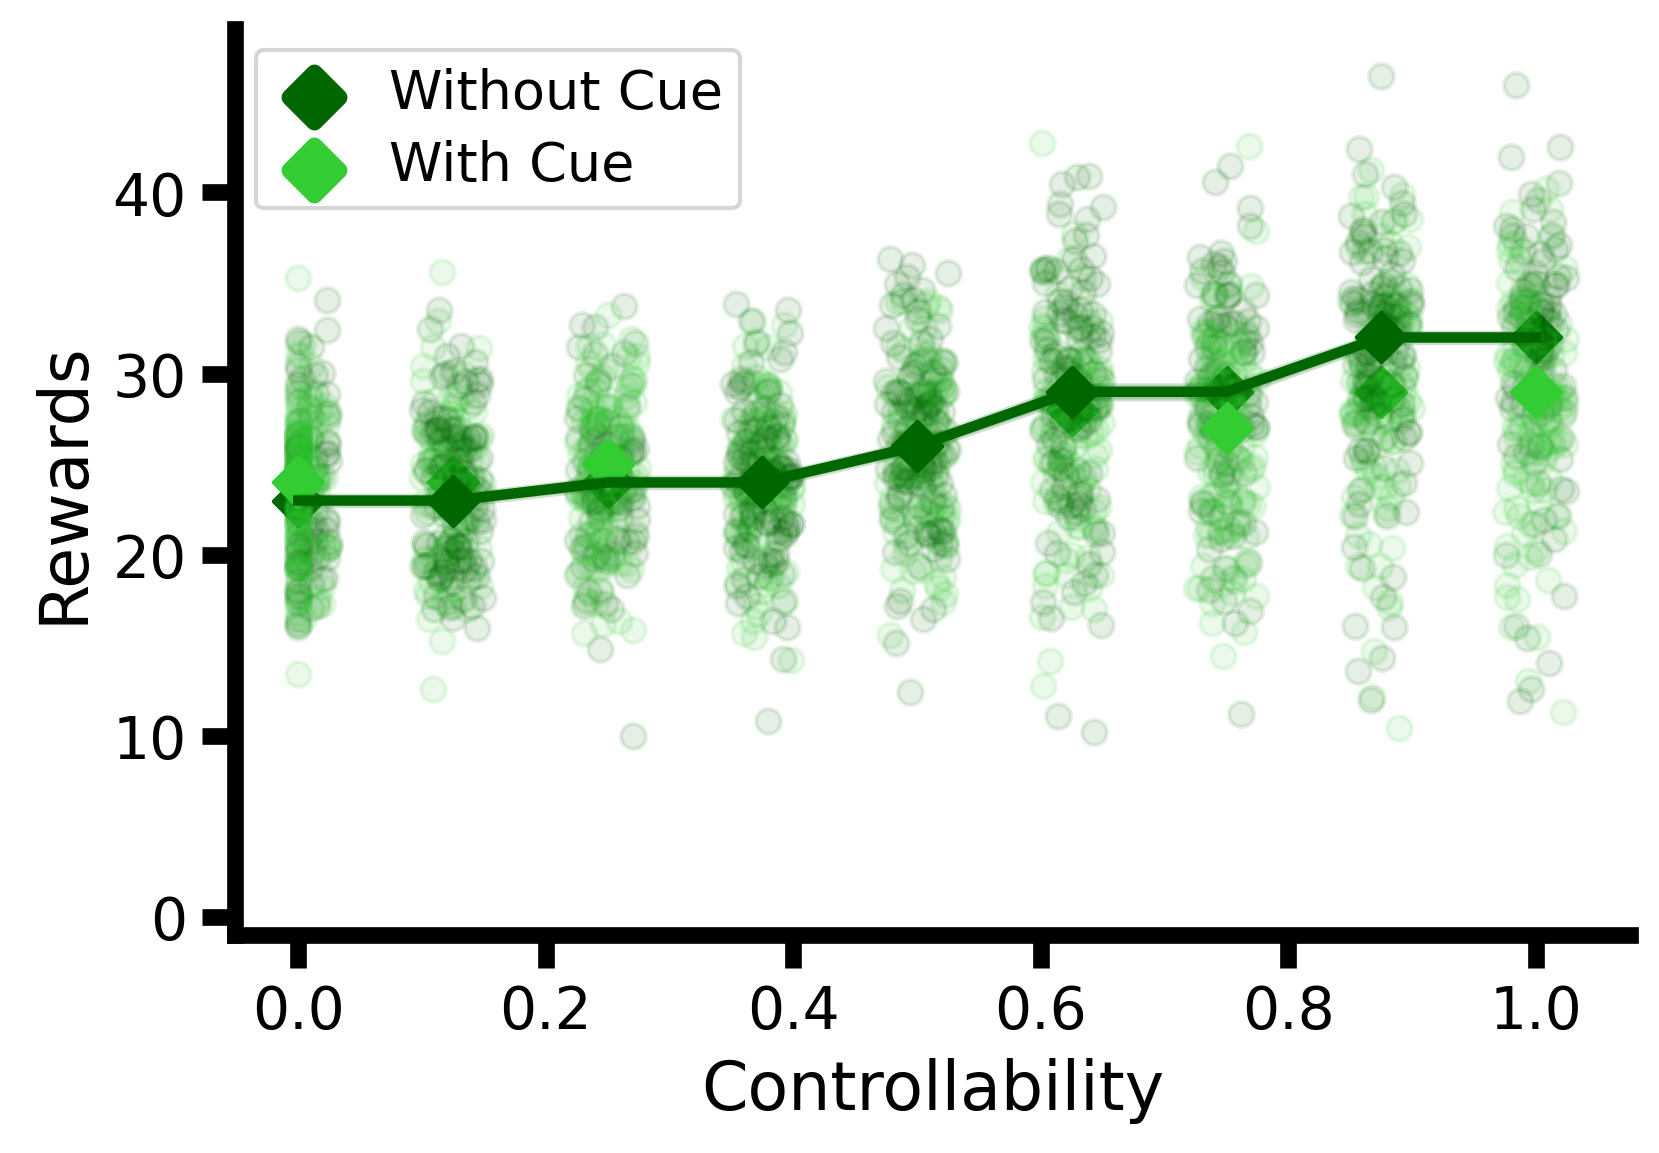

In [53]:
from human_plot_traj_analyses import plot_line_scatter_group

fig = plot_line_scatter_group((n_testA, n_testB), effs_test, (n_trainA, n_trainB), effs_train, ylabel='Rewards', ylim=ylim, xjitter=0.025, yjitter=1, median_over_mean=True,)

In [54]:
fig.savefig(os.path.join(analysis_folder, 'rewards_across_humans.png'))
fig.savefig(os.path.join(analysis_folder, 'rewards_across_humans.svg'))

#### Stats

In [79]:
selected_rewards_tallies = [n_testA[:,-1], n_testA[:,2],n_testA[:,1], n_testA[:,0]]
plotted_levels = effs_to_plot

In [80]:
## MEANS AND SEMS
for level, rewards in zip(plotted_levels, selected_rewards_tallies):
    print("Test Controllability ", level)
    print("Mean ", rewards.mean())
    print("StdErr ", rewards.std()/np.sqrt(rewards.shape[0]))
    print("N", rewards.shape[0])

Test Controllability  1
Mean  30.9
StdErr  0.8272108423961678
N 60
Test Controllability  0.75
Mean  28.0
StdErr  0.7637626158259733
N 60
Test Controllability  0.25
Mean  24.15
StdErr  0.509806608213132
N 60
Test Controllability  0
Mean  23.666666666666668
StdErr  0.5118955333239752
N 60


In [81]:
## TUKEY'S
groups = flatten([[level]*len(obs) for level, obs in zip(plotted_levels, selected_rewards_tallies)])

# Perform Tukey's HSD test
tukey_result = pairwise_tukeyhsd(endog=flatten(selected_rewards_tallies), groups=groups, alpha=0.05)

# Print the results
print(tukey_result)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0   0.25   0.4833 0.9574 -1.9848 2.9515  False
   0.0   0.75   4.3333 0.0001  1.8652 6.8015   True
   0.0    1.0   7.2333    0.0  4.7652 9.7015   True
  0.25   0.75     3.85 0.0004  1.3818 6.3182   True
  0.25    1.0     6.75    0.0  4.2818 9.2182   True
  0.75    1.0      2.9 0.0139  0.4318 5.3682   True
---------------------------------------------------


In [82]:
from human_utils_behavioral_analysis import fit_mixed_effects_glm

glm = fit_mixed_effects_glm(df, 'rewards_tallies')
glm.summary()


<class 'statsmodels.iolib.summary2.Summary'>
"""
              Mixed Linear Model Regression Results
=================================================================
Model:              MixedLM  Dependent Variable:  rewards_tallies
No. Observations:   540      Method:              REML           
No. Groups:         60       Scale:               23.1914        
Min. group size:    9        Log-Likelihood:      -1618.0149     
Max. group size:    9        Converged:           Yes            
Mean group size:    9.0                                          
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              23.667    0.638 37.101 0.000 22.416 24.917
C(efficacy_C)[T.0.125]  0.283    0.879  0.322 0.747 -1.440  2.007
C(efficacy_C)[T.0.25]   0.483    0.879  0.550 0.583 -1.240  2.207
C(efficacy_C)[T.0.375]  0.683    0.879  0.777 0.437 -1.040  2.407
C(efficacy_C)[T.0.5]    2.300    0.879  2.616 0.009  0.577  4.023
C(efficacy_C)[T.0.625]  2.933    0.879  3.336 0.001  1.210  4.657
C(efficacy_C)[T.0.75]   4.333    0.879  4.929 0.000  2.610  6.057
C(efficacy_C)[T.0.875]  5.317    0.879  6.047 0.000  3.593  7.040
C(efficacy_C)[T.1.0]    7.233    0.879  8.227 0.000  5.510  8.957
Group Var               1.223    0.154                           
=================================================================

"""

### APE-trained Neural Networks

In [83]:
from settings_anal import pepe_human_ape_models as ape_models
from utils_project import load_modelrun_files
from settings_anal import pepe_human_ape_traj_timestamp as traj_timestamp

traj_base = os.path.join('data', 'eval', 'pepe', )

cmap_apes = mpl.colormaps['Blues']
test_taus = np.arange(0, 1.1, 0.125)

rewss_taus_ape, counterss_peeks_taus_ape, control_errss_taus_ape, trajss_actions_taus_ape, trajss_logits_taus_ape, trajss_ps_taus_ape = load_modelrun_files(ape_models, traj_timestamp, ape=True, traj_base=traj_base)

In [84]:
fig = plot_comparison_curves_several_runs(test_taus, list(reversed(rewss_taus_ape)), axis_xlabel='Controllability', axis_ylabel='Rewards', label_exp='APE-trained', ylim=ylim, marker='D')

NameError: name 'plot_comparison_curves_several_runs' is not defined

In [ ]:
fig.savefig(os.path.join(analysis_folder, 'rewards_across_ape.png'))
fig.savefig(os.path.join(analysis_folder, 'rewards_across_ape.svg'))

### No-APE Networks

In [85]:
from settings_anal import pepe_human_control_models as control_models
from utils_project import load_modelrun_files
from settings_anal import pepe_human_control_traj_timestamp as traj_timestamp

traj_base = os.path.join('data', 'eval', 'pepe', )

cmap_control = mpl.colormaps['Oranges']
taus_to_plot = [0, 0.5, 1]

rewss_taus_control, counterss_peeks_taus_control, _, trajss_actions_taus_control, trajss_logits_taus_control, trajss_ps_taus_control = load_modelrun_files(control_models, traj_timestamp, ape=False, traj_base=traj_base)

In [86]:
fig = plot_comparison_curves_several_runs(x_control=test_taus, y_control=list(reversed(rewss_taus_control)), axis_xlabel='Controllability', axis_ylabel='Rewards', label_control='no APE', ylim=ylim, marker='D')

NameError: name 'plot_comparison_curves_several_runs' is not defined

In [87]:
fig.savefig(os.path.join(analysis_folder, 'rewards_across_noape.png'))
fig.savefig(os.path.join(analysis_folder, 'rewards_across_noape.svg'))

## Stats
### Likelihood estimation

In [88]:
from human_utils_project import get_clean_data, sort_train_test

day = 'day2'
exp_date = '24-01-22-29'

day1_test_mask_cutoff = {
    "groupA": {"lower": 10, "upper": 90},
    "groupB": {"lower": 8, "upper": 72}
}

human_data_file_base = '/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis'

group = None

df, effs_train, effs_test, test_start = get_clean_data(day = int(day[-1]), exp_date = exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, group=group, file_base=human_data_file_base)

cmap_humans = mpl.colormaps['Greens']

In [ ]:
df_file_A_22 = '/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis/results/behavior/20240527162302_behavior_diff_effs_24-01-22_day2_with_nets_groupA.pkl'
df_file_B_22 = '/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis/results/behavior/20240527162823_behavior_diff_effs_24-01-22_day2B_with_nets_groupB.pkl'

df_file_A_29 = '/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis/results/behavior/20240527164021_behavior_diff_effs_24-01-29_day2_with_nets_groupA.pkl'
df_file_B_29 = '/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis/results/behavior/20240527164530_behavior_diff_effs_24-01-29_day2B_with_nets_groupB.pkl'

df_A = pd.read_pickle(df_file_A_22)
df_B = pd.read_pickle(df_file_B_22)

df_A_29 = pd.read_pickle(df_file_A_29)
df_B_29 = pd.read_pickle(df_file_B_29)

df_A = pd.concat([df_A, df_A_29])
df_B = pd.concat([df_B, df_B_29])

## only keep the rows in df_A that match an index in df (keeping in mind there might be missing keys)
df_A = df_A[df_A.index.isin(df.index)]
df_B = df_B[df_B.index.isin(df.index)]

In [ ]:
from settings_anal import pepe_human_ape_models as ape_models
from settings_anal import pepe_human_control_models as control_models
from human_utils_project import sort_train_test


test_liks_A_ape = []
test_liks_A_noape = []
test_liks_B_ape = []
test_liks_B_noape = []

for model in ape_models:
    train_liks_A, test_liks_A = sort_train_test(df_A['step_l_%d' %model], df_A['effs'], test_start=5)
    test_liks_A_ape.append(test_liks_A)

for model in control_models:
    train_liks_A, test_liks_A = sort_train_test(df_A['step_l_%d' %model], df_A['effs'], test_start=5)
    test_liks_A_noape.append(test_liks_A)

for model in ape_models:
    train_liks_B, test_liks_B = sort_train_test(df_B['step_l_%d' %model], df_B['effs'], test_start=5)
    test_liks_B_ape.append(test_liks_B)

for model in control_models:
    train_liks_B, test_liks_B = sort_train_test(df_B['step_l_%d' %model], df_B['effs'], test_start=5)
    test_liks_B_noape.append(test_liks_B)

test_liks_A_ape = np.array(test_liks_A_ape)
test_liks_A_noape = np.array(test_liks_A_noape)
test_liks_B_ape = np.array(test_liks_B_ape)
test_liks_B_noape = np.array(test_liks_B_noape)

test_liks_ape = [test_liks_A_ape[:,:,-1].mean(axis=(0,-1)), test_liks_B_ape[:,:,2].mean(axis=(0,-1)), test_liks_A_ape[:,:,0].mean(axis=(0,-1))]
test_liks_noape = [test_liks_A_noape[:,:,-1].mean(axis=(0,-1)), test_liks_B_noape[:,:,2].mean(axis=(0,-1)), test_liks_A_noape[:,:,0].mean(axis=(0,-1))]
plotted_levels = [1, 0.5, 0]


In [ ]:
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import multipletests


## MEANS AND SEMS
print("Overall N", len(df))

p_values = []

for level, liks, liks_noape in zip(plotted_levels, test_liks_ape, test_liks_noape):
    ## AVERAGE STATS
    print("Test Controllability ", level)
    print("Mean APE", liks.mean())
    print("StdErr APE", liks.std()/np.sqrt(liks.shape[0]))
    print("N APE", liks.shape[0])
    
    print("Mean NOAPE", liks_noape.mean())
    print("StdErr NOAPE", liks_noape.std()/np.sqrt(liks_noape.shape[0]))
    print("N NOAPE", liks_noape.shape[0])

    ## paired t-test
    ttest = ttest_rel(liks, liks_noape, alternative='greater')
    print(ttest)
    p_values.append(ttest.pvalue)

## MULTIPLE COMPARISONS
rejects, p_values_corrected, _, _ = multipletests(p_values, alpha=0.05, method='holm')
print(rejects)
print(p_values_corrected)

Overall N 111
Test Controllability  1
Mean APE 0.64828455
StdErr APE 0.032885752642098774
N APE 46
Mean NOAPE 0.5193321
StdErr NOAPE 0.01781263220435191
N NOAPE 46
TtestResult(statistic=4.382374171570158, pvalue=3.478475123286644e-05, df=45)
Test Controllability  0.5
Mean APE 0.60246795
StdErr APE 0.02622862639349929
N APE 65
Mean NOAPE 0.48996818
StdErr NOAPE 0.01234893236883643
N NOAPE 65
TtestResult(statistic=4.561404088450951, pvalue=1.1774297586680263e-05, df=64)
Test Controllability  0
Mean APE 0.5624307
StdErr APE 0.0219809138864937
N APE 46
Mean NOAPE 0.5342141
StdErr NOAPE 0.02146576568873027
N NOAPE 46
TtestResult(statistic=1.0590984795602612, pvalue=0.1476034607207268, df=45)
[ True  True False]
[6.95695025e-05 3.53228928e-05 1.47603461e-01]


In [ ]:
## TUKEY'S
groups = flatten([[level]*len(obs) for level, obs in zip(plotted_levels, cropped_observations)])

# Perform Tukey's HSD test
tukey_result = pairwise_tukeyhsd(endog=flatten(cropped_observations), groups=groups, alpha=0.05)

# Print the results
print(tukey_result)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
   0.0    0.5   0.0366 0.0451 0.0006 0.0726   True
   0.0    1.0   0.0739    0.0  0.035 0.1129   True
   0.5    1.0   0.0373 0.0405 0.0013 0.0733   True
--------------------------------------------------
